# Module 3 Project

* Student name: **Will Dougherty**
* Student pace: **self paced**
* Scheduled project review date/time: **18 March 2022, 2:00-2:45 PM**
* Blog post URL: **TBD**
* Presentation Video URL: **TBD**

## Description

This project will be tackling the Tanzanian Water Pump dataset, provided as part of a DrivenData competition. I will use the methodologies I have learned in Module 3 to analyze, clean, and model this data to produce a workable model that can predict the functionality of a water pump on a level competitive with the best models in the competition.

In addition, I will approach this with a set of business goals created to simulate how I would be interacting with this problem in the real world.

## Business Problem

As a data scientist for the Tanzanian Government, I am tasked with:
* Building a predictive model for water pump functionality
* Identifying efficient ways of allocating resources to inspect/repair pumps
* Make recommendations for future data collection/cleanup to create better data sets and models

## Dataset and Methodology

There are nearly 75,000 data points representing as many water pumps spread over the entire nation of Tanzania. The data provided consists of a training set of 59,400 pumps which includes their status_group (target variable) data, and a test set of 14,850 pumps without status_group data. 

Thus, all eda / cleaning / initial modelling will be done with the training set to prevent data leakage, and once decisions have been made as to methodology, the test set will be used at the end to create the submission to be scored on the DrivenData website.

<a id="contents"></a>
# Contents

## 1. [Setup / Load Data](#setup)
## 2. [EDA](#eda)
## 3. [Data Cleaning](#clean)
## 4. [Modelling](#model)
## 5. [Data Insights](#insights)
## 6. [Conclusion](#conclusion)
******************

<a id="setup"></a>
# 1. Setup / Load Data
[Back to Top](#contents) | [Next Section](#eda)

### 1.1 Import packages

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from difflib import SequenceMatcher
import missingno as msno
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

### 1.2 Custom Functions

In [2]:
def dupe_check(df):
    '''
    Given a dataframe, this checks for duplicate entries.
    
    Arguments:
        df: DataFrame
    
    Returns:
        Nothing
        
    Prints:
        Number of duplicates
        Total number of records
        Percentage of total records that are duplicates
    '''
    dupes = df.duplicated(keep='first').sum()
    print(f"Number of duplicates: {dupes}")
    print(f"Total records: {len(df)}")
    print(f"% of duplicated: {(dupes/len(df))*100}")

In [3]:
def dist_check (df, x, sort=True):
    '''
    Given a dataframe, this returns a dataframe with numerical distribution data
        relating a given feature to the target variable ('status_group')
    
    Arguments:
        df: DataFrame
        x: feature to be analyzed
        sort: whether to sort the values by '# of pumps' (default=True)
    
    Returns:
        Dataframe with distribution data
    '''
    grouped = df.groupby([x, 'status_group'])['id'].count().reset_index()
    pivot = grouped.pivot_table(index = x, columns = 'status_group', fill_value = 0)
    pivot_cols = pivot.columns.tolist()
    index = pd.Index([str(e[1]) for e in pivot_cols])
    pivot.columns = index
    all_pumps = len(df)
    
    pivot['# of pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
    pivot['% of all pumps'] =((pivot['# of pumps']/all_pumps)*100).round(1)
    pivot['% functional'] = ((pivot['functional']/pivot['# of pumps'])*100).round(1)
    pivot['% non functional'] = ((pivot['non functional']/pivot['# of pumps'])*100).round(1)
    pivot['% functional needs repair'] = ((pivot['functional needs repair']/pivot['# of pumps'])*100).round(1)
    
    pivot = pivot.drop(['functional', 'functional needs repair', 'non functional'], axis=1)
    
    if sort:
        return(pivot.sort_values('# of pumps', ascending=False))
    return(pivot)

In [4]:
def df_cat_qr(df):
    '''
    Given a dataframe, this returns a quality report dataframe with various measures
        of missing values, mode, etc of all categorical ('object' dtype) features.
    
    Arguments:
        df: DataFrame
    
    Returns:
        Dataframe with columns:
            Unique values
            Missing Values
            Missing %
            Mode
            Mode Freq
            Mode %
    '''
    cats = df.select_dtypes(include=['object', 'datetime64[ns]']).columns.tolist()
    
    uniques = pd.DataFrame(columns=['Unique values'])
    for row in list(df[cats].columns.values):
        uniques.loc[row] = [df[cats][row].nunique()]
    
    missing_vals = pd.DataFrame(df[cats].isnull().sum(), columns=['Missing Values'])
    
    cat_qr = uniques.join(missing_vals)
    
    cat_qr['Missing %'] = ((cat_qr['Missing Values']/int(len(df)))*100).round(1)
    
    #cat_qr['Mode'] = pd.DataFrame(df[cats].mode(), columns=['Mode'])
    mode_values = pd.DataFrame(columns=['Mode'])
    for row in list(df[cats].columns.values): 
        mode_values.loc[row] = [df[cats][row].mode()[0]]
    
    cat_qr = cat_qr.join(mode_values)
    
    mode_freqs = []
    for row in cats:
        mode_freqs.append(df[row].value_counts()[df[row].mode()[0]])
    cat_qr['Mode Freq'] = mode_freqs
    cat_qr['Mode %'] = ((cat_qr['Mode Freq']/len(df))*100).round(1)
    
    return cat_qr

### 1.3 Load Data

In [5]:
x_train = pd.read_csv('x_train.csv')

x_test = pd.read_csv('x_test.csv')

y_train = pd.read_csv('y_train.csv')

X = pd.concat([x_train, x_test])

train = pd.merge(x_train, y_train, on='id')

In [6]:
len(x_test), len(x_train)

(14850, 59400)

<a id="eda"></a>
# 2. EDA
[Back to Top](#contents) | [Previous Section](#setup) | [Next Section](#clean)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
train.date_recorded.head()

0    2011-03-14
1    2013-03-06
2    2013-02-25
3    2013-01-28
4    2011-07-13
Name: date_recorded, dtype: object

In [9]:
# Let's convert the date_recorded data to datetime:
X.date_recorded = pd.to_datetime(X.date_recorded)
train.date_recorded = pd.to_datetime(train.date_recorded)

In [10]:
pd.DataFrame(train.date_recorded.describe())

date_recorded
count                 59400
unique                  356
top     2011-03-15 00:00:00
freq                    572
first   2002-10-14 00:00:00
last    2013-12-03 00:00:00

### 2.1 Numerical Data

In [11]:
nums = train.select_dtypes(include=['int','int64','float'])
nums.isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

In [12]:
dupe_check(nums)

Number of duplicates: 0
Total records: 59400
% of duplicated: 0.0


In [13]:
num_qr = train.describe().round(1)
num_qr

id  amount_tsh  gps_height  longitude  latitude  num_private  \
count  59400.0     59400.0     59400.0    59400.0   59400.0      59400.0   
mean   37115.1       317.7       668.3       34.1      -5.7          0.5   
std    21453.1      2997.6       693.1        6.6       2.9         12.2   
min        0.0         0.0       -90.0        0.0     -11.6          0.0   
25%    18519.8         0.0         0.0       33.1      -8.5          0.0   
50%    37061.5         0.0       369.0       34.9      -5.0          0.0   
75%    55656.5        20.0      1319.2       37.2      -3.3          0.0   
max    74247.0    350000.0      2770.0       40.3      -0.0       1776.0   

       region_code  district_code  population  construction_year  
count      59400.0        59400.0     59400.0            59400.0  
mean          15.3            5.6       179.9             1300.7  
std           17.6            9.6       471.5              951.6  
min            1.0            0.0         0.0                0.0  
25%            5.0            2.0         0.0                0.0  
50%           12.0            3.0        25.0             1986.0  
75%           17.0            5.0       215.0             2004.0  
max           99.0           80.0     30500.0             2013.0

In [14]:
unique_nums = pd.DataFrame(columns=['Unique Values'])
for row in nums.columns.values:
    unique_nums.loc[row] = [nums[row].nunique()]
    
unique_nums

Unique Values
id                        59400
amount_tsh                   98
gps_height                 2428
longitude                 57516
latitude                  57517
num_private                  65
region_code                  27
district_code                20
population                 1049
construction_year            55

In [15]:
# id / region_code / district_code / num_private all seem to be categorical instead of numerical in nature
train[['id','region_code','district_code','num_private']] = \
    train[['id','region_code','district_code','num_private']].astype('object')

X[['id','region_code','district_code','num_private']] = \
    X[['id','region_code','district_code','num_private']].astype('object')

In [16]:
def display_num_qr(x):
    '''
    Displays .info() data for a given feature, from the num_qr dataframe.
    
    Arguments:
        x: feature
    
    Returns:
        Nothing
        
    Displays:
        The dataframe info for the given feature
        # of unique values
    '''
    display(num_qr[x])
    display(unique_nums.loc[[x]])

### 2.2 Categorical Data

In [17]:
cat_qr = df_cat_qr(train)
cat_qr.sort_values('Unique values', ascending=0)

Unique values  Missing Values  Missing %  \
id                            59400               0        0.0   
wpt_name                      37400               0        0.0   
subvillage                    19287             371        0.6   
scheme_name                    2696           28166       47.4   
installer                      2145            3655        6.2   
ward                           2092               0        0.0   
funder                         1897            3635        6.1   
date_recorded                   356               0        0.0   
lga                             125               0        0.0   
num_private                      65               0        0.0   
region_code                      27               0        0.0   
region                           21               0        0.0   
district_code                    20               0        0.0   
extraction_type                  18               0        0.0   
extraction_type_group            13               0        0.0   
management                       12               0        0.0   
scheme_management                12            3877        6.5   
source                           10               0        0.0   
basin                             9               0        0.0   
water_quality                     8               0        0.0   
waterpoint_type                   7               0        0.0   
extraction_type_class             7               0        0.0   
payment                           7               0        0.0   
payment_type                      7               0        0.0   
source_type                       7               0        0.0   
waterpoint_type_group             6               0        0.0   
quality_group                     6               0        0.0   
management_group                  5               0        0.0   
quantity                          5               0        0.0   
quantity_group                    5               0        0.0   
source_class                      3               0        0.0   
status_group                      3               0        0.0   
public_meeting                    2            3334        5.6   
permit                            2            3056        5.1   
recorded_by                       1               0        0.0   

                                          Mode  Mode Freq  Mode %  
id                                           0          1     0.0  
wpt_name                                  none       3563     6.0  
subvillage                            Madukani        508     0.9  
scheme_name                                  K        682     1.1  
installer                                  DWE      17402    29.3  
ward                                     Igosi        307     0.5  
funder                  Government Of Tanzania       9084    15.3  
date_recorded              2011-03-15 00:00:00        572     1.0  
lga                                     Njombe       2503     4.2  
num_private                                  0      58643    98.7  
region_code                                 11       5300     8.9  
region                                  Iringa       5294     8.9  
district_code                                1      12203    20.5  
extraction_type                        gravity      26780    45.1  
extraction_type_group                  gravity      26780    45.1  
management                                 vwc      40507    68.2  
scheme_management                          VWC      36793    61.9  
source                                  spring      17021    28.7  
basin                            Lake Victoria      10248    17.3  
water_quality                             soft      50818    85.6  
waterpoint_type             communal standpipe      28522    48.0  
extraction_type_class                  gravity      26780    45.1  
payment                              never pay      25348    42.7  
payment_type 

In [18]:
# Let's look at the low-cardinality features first:
low_card_qr = cat_qr[cat_qr['Unique values'] < 30]

low_card_qr

Unique values  Missing Values  Missing %  \
basin                             9               0        0.0   
region                           21               0        0.0   
region_code                      27               0        0.0   
district_code                    20               0        0.0   
public_meeting                    2            3334        5.6   
recorded_by                       1               0        0.0   
scheme_management                12            3877        6.5   
permit                            2            3056        5.1   
extraction_type                  18               0        0.0   
extraction_type_group            13               0        0.0   
extraction_type_class             7               0        0.0   
management                       12               0        0.0   
management_group                  5               0        0.0   
payment                           7               0        0.0   
payment_type                      7               0        0.0   
water_quality                     8               0        0.0   
quality_group                     6               0        0.0   
quantity                          5               0        0.0   
quantity_group                    5               0        0.0   
source                           10               0        0.0   
source_type                       7               0        0.0   
source_class                      3               0        0.0   
waterpoint_type                   7               0        0.0   
waterpoint_type_group             6               0        0.0   
status_group                      3               0        0.0   

                                          Mode  Mode Freq  Mode %  
basin                            Lake Victoria      10248    17.3  
region                                  Iringa       5294     8.9  
region_code                                 11       5300     8.9  
district_code                                1      12203    20.5  
public_meeting                            True      51011    85.9  
recorded_by            GeoData Consultants Ltd      59400   100.0  
scheme_management                          VWC      36793    61.9  
permit                                    True      38852    65.4  
extraction_type                        gravity      26780    45.1  
extraction_type_group                  gravity      26780    45.1  
extraction_type_class                  gravity      26780    45.1  
management                                 vwc      40507    68.2  
management_group                    user-group      52490    88.4  
payment                              never pay      25348    42.7  
payment_type                         never pay      25348    42.7  
water_quality                             soft      50818    85.6  
quality_group                             good      50818    85.6  
quantity                                enough      33186    55.9  
quantity_group                          enough      33186    55.9  
source                                  spring      17021    28.7  
source_type                             spring      17021    28.7  
source_class                       groundwater      45794    77.1  
waterpoint_type             communal standpipe      28522    48.0  
waterpoint_type_group       communal standpipe      34625    58.3  
status_group                        functional      32259    54.3

In [19]:
# plot of feature counts

low_card_features = low_card_qr.index.to_list()
len(low_card_features)

25

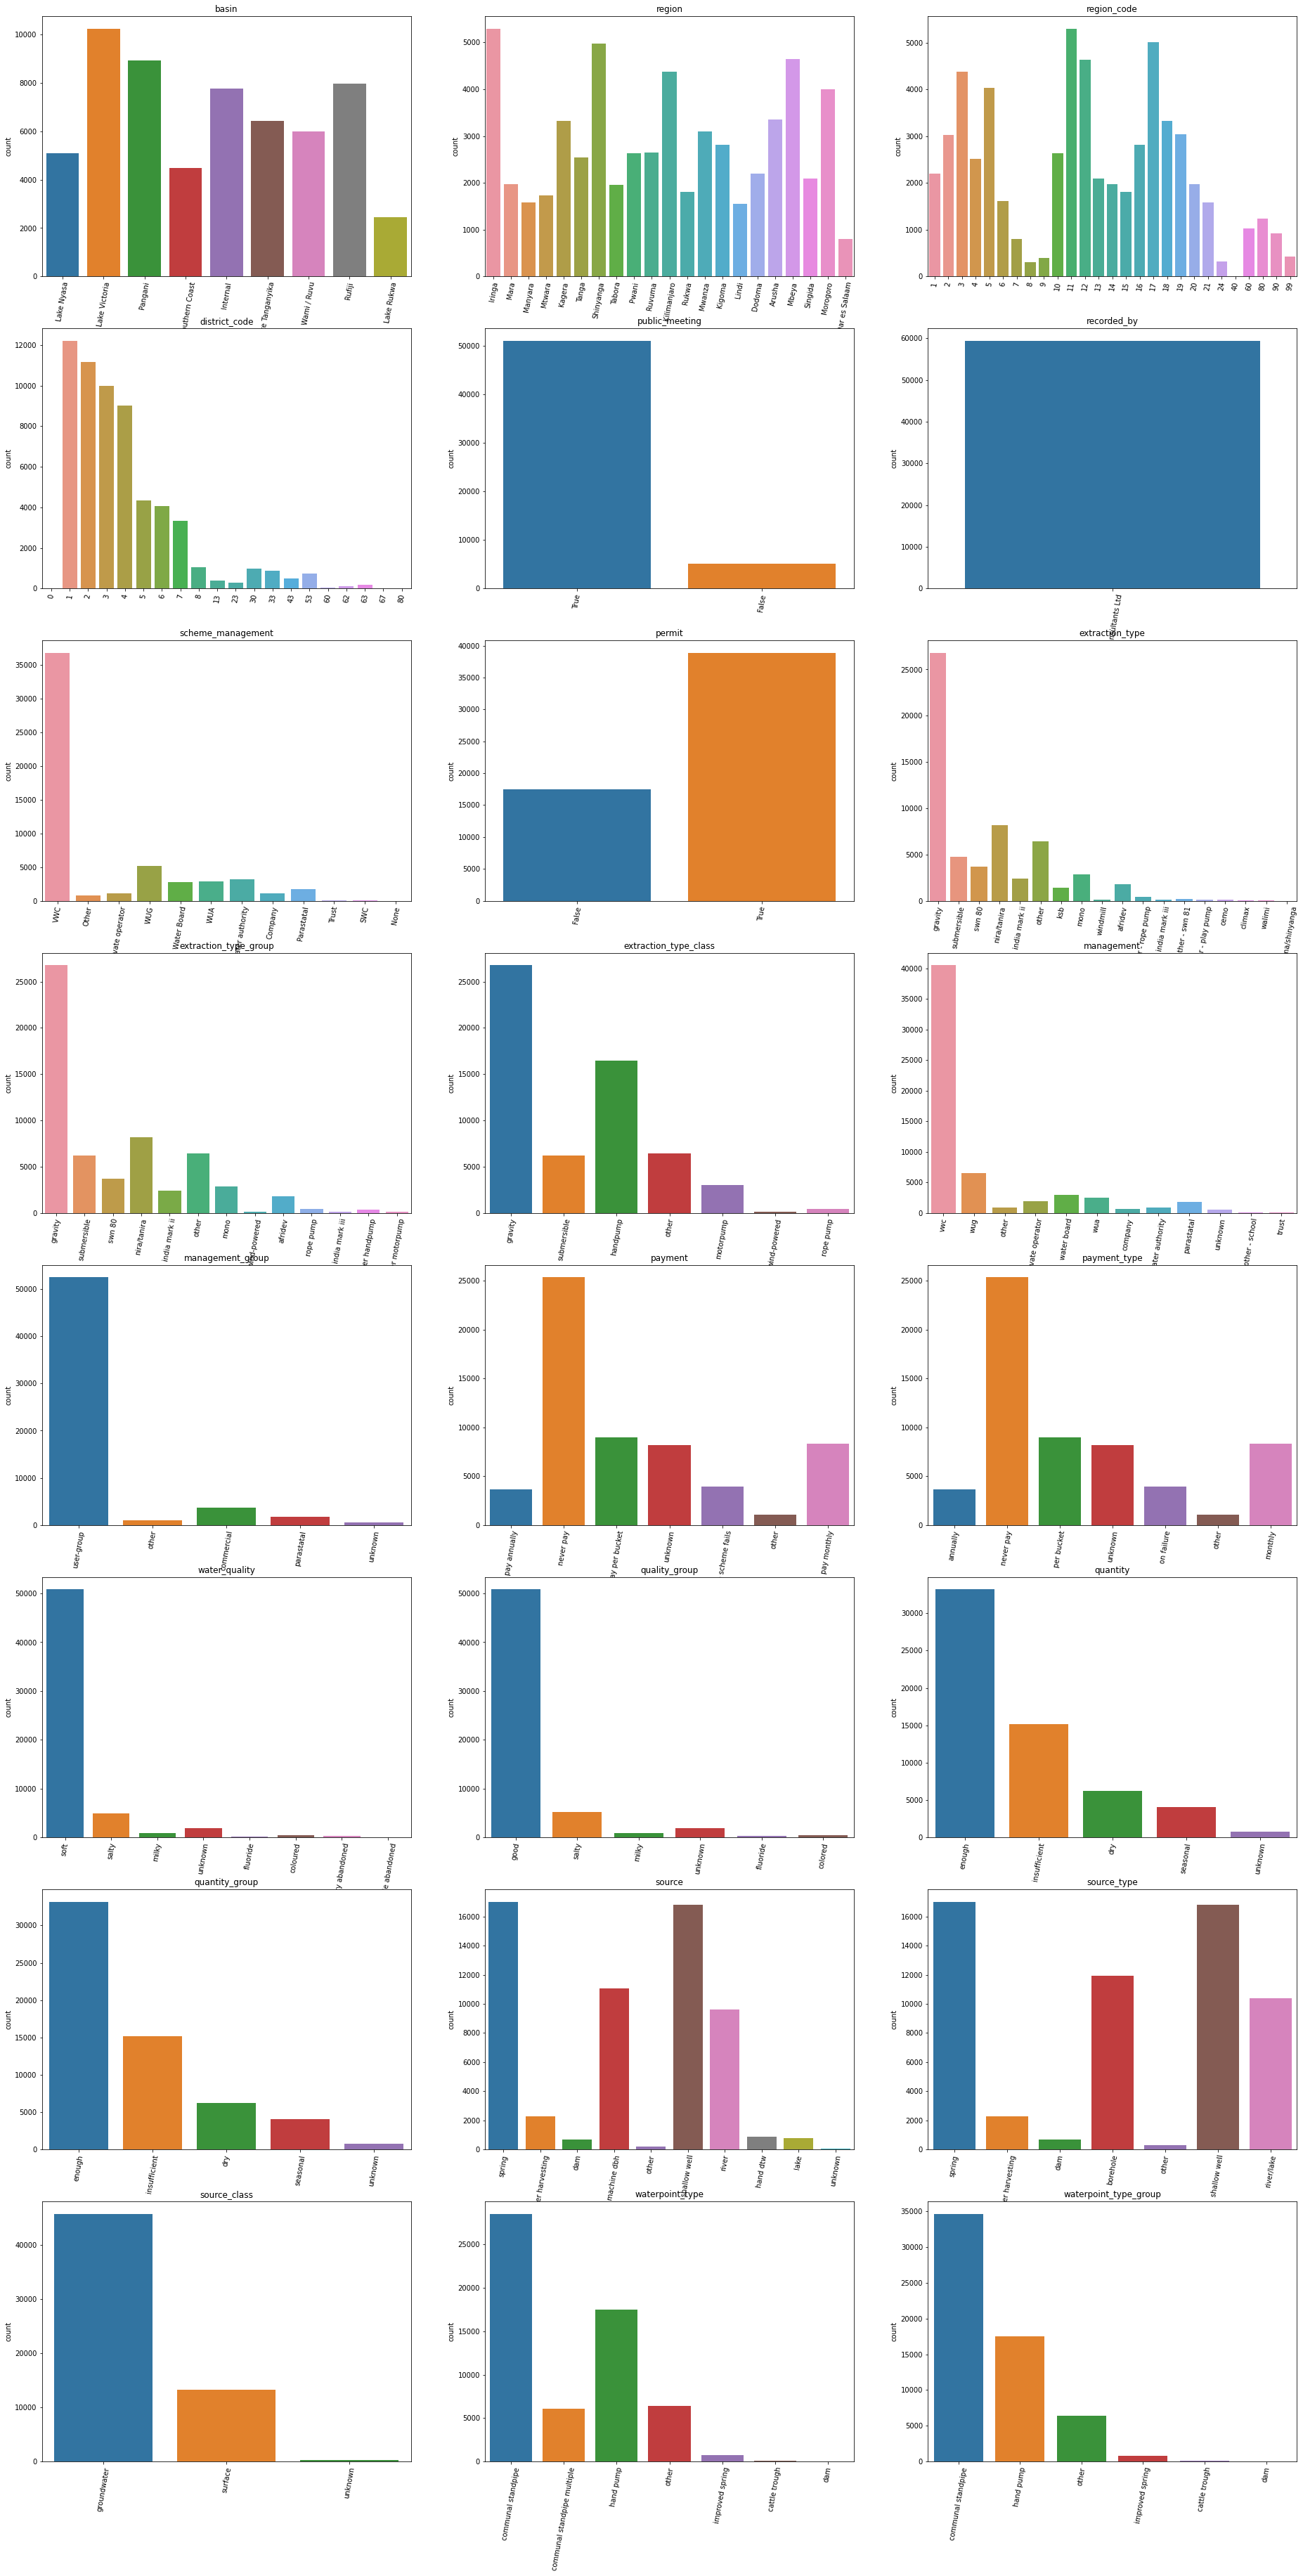

In [20]:
# I'd like to only have 24 features since it's a nice round number for plotting, and status_group is the target so
# I'm clearly going to look at that more in-depth later

low_card_features = low_card_features[:-1]

fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(32,64))
feature = 0

for i in range(8):
    for j in range(3):
        ax = sns.countplot(data=train, x=low_card_features[feature], ax=axes[i][j])
        ax.set_title(low_card_features[feature])
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
        feature += 1

In [21]:
# Right off, we can safely remove several features due to redundancy:

dupe_cols = ['payment_type', 'quantity_group']

train = train.drop(labels=dupe_cols, axis=1)
X = X.drop(labels=dupe_cols, axis=1)

## 2.3 Feature-by-feature EDA

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  object        
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             59400 non-null  int64         
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  object        
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

I don't need to address 'id' since it just indentifies each water pump.

### 2.3.1 amount_tsh

In [23]:
display_num_qr('amount_tsh')

count     59400.0
mean        317.7
std        2997.6
min           0.0
25%           0.0
50%           0.0
75%          20.0
max      350000.0
Name: amount_tsh, dtype: float64

Unique Values
amount_tsh            98

In [24]:
train['amount_tsh'].value_counts(normalize=1).head()

0.0       0.700993
500.0     0.052222
50.0      0.041616
1000.0    0.025051
20.0      0.024630
Name: amount_tsh, dtype: float64

In [25]:
# The vast majority are 0.0, so maybe there's something in there?
dist_check(train, 'amount_tsh')

# of pumps  % of all pumps  % functional  % non functional  \
amount_tsh                                                               
0.0              41639            70.1          47.3              45.4   
500.0             3102             5.2          71.8              19.4   
50.0              2472             4.2          66.1              29.6   
1000.0            1488             2.5          75.3              18.9   
20.0              1463             2.5          66.3              28.5   
...                ...             ...           ...               ...   
26.0                 1             0.0         100.0               0.0   
5400.0               1             0.0         100.0               0.0   
12.0                 1             0.0         100.0               0.0   
6300.0               1             0.0         100.0               0.0   
350000.0             1             0.0         100.0               0.0   

            % functional needs repair  
amount_tsh                             
0.0                               7.3  
500.0                             8.8  
50.0                              4.3  
1000.0                            5.8  
20.0                              5.2  
...                               ...  
26.0                              0.0  
5400.0                            0.0  
12.0                              0.0  
6300.0                            0.0  
350000.0                          0.0  

[98 rows x 5 columns]

<AxesSubplot:xlabel='amount_tsh', ylabel='% functional'>

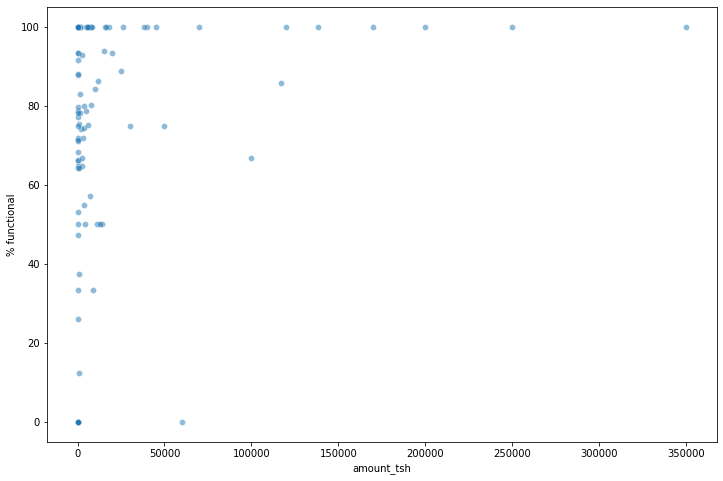

In [26]:
tsh_dist = dist_check(train, 'amount_tsh')
plt.figure(figsize=(12,8))
sns.scatterplot(data=tsh_dist, x='amount_tsh', y='% functional', alpha=.5)

In [27]:
# Let's check just 0.0 vs all others

tsh = train.copy()
tsh['tsh_missing'] = np.where(tsh['amount_tsh']==0.0, 0, 1)

dist_check(tsh, 'tsh_missing')

# of pumps  % of all pumps  % functional  % non functional  \
tsh_missing                                                               
0                 41639            70.1          47.3              45.4   
1                 17761            29.9          70.7              22.2   

             % functional needs repair  
tsh_missing                             
0                                  7.3  
1                                  7.1

In [28]:
# Perhaps the 0.0 value holds some value since they are much less likely to be functional

In [29]:
# Impute NaN for 0.0 values in amount_tsh

train['amount_tsh_imp'] = np.where(train['amount_tsh']==0.0, 'NaN', train['amount_tsh']).astype('float64')
X['amount_tsh_imp'] = np.where(X['amount_tsh']==0.0, 'NaN', X['amount_tsh']).astype('float64')
train[['amount_tsh','amount_tsh_imp']].head()

amount_tsh  amount_tsh_imp
0      6000.0          6000.0
1         0.0             NaN
2        25.0            25.0
3         0.0             NaN
4         0.0             NaN

### 2.3.2 date_recorded

In [30]:
cat_qr.loc[['date_recorded']]

Unique values  Missing Values  Missing %                 Mode  \
date_recorded           356               0        0.0  2011-03-15 00:00:00   

               Mode Freq  Mode %  
date_recorded        572     1.0

In [31]:
train['date_recorded'].describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [32]:
date = train.copy()
date['recorded_year'] = pd.DatetimeIndex(date['date_recorded']).year

dist_check(date, 'recorded_year', sort=0)

# of pumps  % of all pumps  % functional  % non functional  \
recorded_year                                                               
2002                    1             0.0         100.0               0.0   
2004                   30             0.1          33.3              63.3   
2011                28674            48.3          56.6              37.1   
2012                 6424            10.8          48.7              45.7   
2013                24271            40.9          53.2              38.0   

               % functional needs repair  
recorded_year                             
2002                                 0.0  
2004                                 3.3  
2011                                 6.3  
2012                                 5.6  
2013                                 8.8

In [33]:
# This will be handy to 'age' the pumps, though the vast majority are recorded in 2011 and 2013

In [34]:
train['recorded_year'] = date['recorded_year'].astype('int64')

X['recorded_year'] = pd.DatetimeIndex(X['date_recorded']).year.astype('int64')

train['recorded_year']

0        2011
1        2013
2        2013
3        2013
4        2011
         ... 
59395    2013
59396    2011
59397    2011
59398    2011
59399    2011
Name: recorded_year, Length: 59400, dtype: int64

### 2.3.3 funder

In [35]:
cat_qr.loc[['funder']]

Unique values  Missing Values  Missing %                    Mode  \
funder          1897            3635        6.1  Government Of Tanzania   

        Mode Freq  Mode %  
funder       9084    15.3

In [36]:
dist_check(train, 'funder').head(10)

# of pumps  % of all pumps  % functional  \
funder                                                             
Government Of Tanzania        9084            15.3          41.0   
Danida                        3114             5.2          55.0   
Hesawa                        2202             3.7          42.5   
Rwssp                         1374             2.3          58.6   
World Bank                    1349             2.3          40.4   
Kkkt                          1287             2.2          56.2   
World Vision                  1246             2.1          59.6   
Unicef                        1057             1.8          56.8   
Tasaf                          877             1.5          56.2   
District Council               843             1.4          44.8   

                        % non functional  % functional needs repair  
funder                                                               
Government Of Tanzania              51.3                        7.7  
Danida                              39.9                        5.1  
Hesawa                              47.0                       10.5  
Rwssp                               33.5                        7.9  
World Bank                          52.4                        7.2  
Kkkt                                38.7                        5.1  
World Vision                        29.9                       10.5  
Unicef                              33.9                        9.4  
Tasaf                               36.5                        7.3  
District Council                    49.8                        5.3

In [37]:
# Very high cardinality and lots of missing data - this is unlikely to be useful,
# unless they can be combined / grouped together

### 2.3.4 installer

In [38]:
cat_qr.loc[['installer']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
installer          2145            3655        6.2  DWE      17402    29.3

In [39]:
dist_check(train, 'installer').head(10)

# of pumps  % of all pumps  % functional  \
installer                                                      
DWE                      17402            29.3          54.2   
Government                1825             3.1          29.3   
RWE                       1206             2.0          25.2   
Commu                     1060             1.8          68.3   
DANIDA                    1050             1.8          51.6   
KKKT                       898             1.5          47.0   
Hesawa                     840             1.4          56.5   
0                          777             1.3          57.3   
TCRS                       707             1.2          41.0   
Central government         622             1.0          27.0   

                    % non functional  % functional needs repair  
installer                                                        
DWE                             36.5                        9.3  
Government                      56.7                       14.0  
RWE                             63.4                       11.4  
Commu                           28.7                        3.0  
DANIDA                          40.5                        7.9  
KKKT                            46.1                        6.9  
Hesawa                          41.4                        2.0  
0                               42.3                        0.4  
TCRS                            53.0                        5.9  
Central government              72.3                        0.6

In [40]:
# Similar to 'funder', lots of cardinality and missing data. Needs grouping.

### 2.3.5 gps_height

In [41]:
display_num_qr('gps_height')

count    59400.0
mean       668.3
std        693.1
min        -90.0
25%          0.0
50%        369.0
75%       1319.2
max       2770.0
Name: gps_height, dtype: float64

Unique Values
gps_height          2428

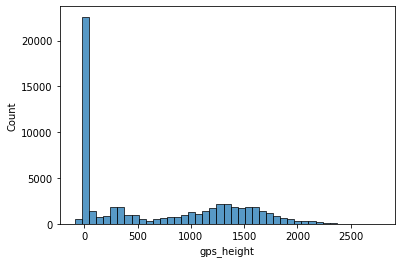

In [42]:
sns.histplot(train['gps_height']);

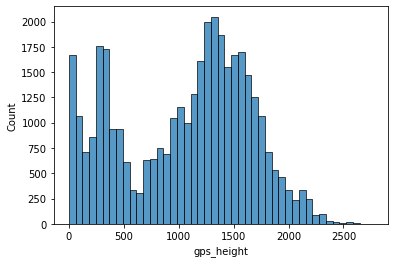

In [43]:
sns.histplot(train[train['gps_height']>0]['gps_height']);

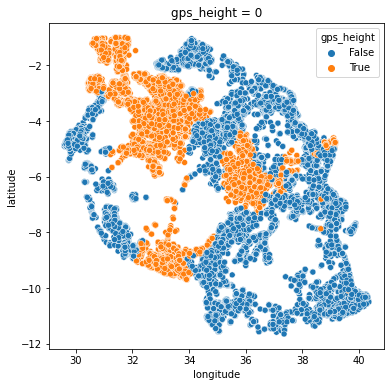

In [44]:
plt.figure(figsize=(6,6,))

nonzero = train[train['longitude']!=0]

ax = sns.scatterplot(x=nonzero['longitude'], y=nonzero['latitude'], hue=nonzero['gps_height']==0)
ax.set_title('gps_height = 0');

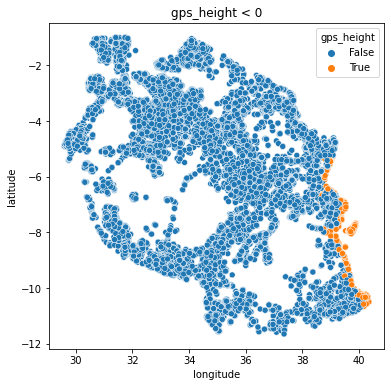

In [45]:
plt.figure(figsize=(6,6,))

nonzero = train[train['longitude']!=0]

ax = sns.scatterplot(x=nonzero['longitude'], y=nonzero['latitude'], hue=nonzero['gps_height']<0)
ax.set_title('gps_height < 0');

In [46]:
# It appears that <0 values are on the coast, which makes sense;
# =0 values are spread over entire regions, which makes me think
# that they are missing values. This needs to be imputed as NaN, and dealt with later.

In [47]:
train['gps_height'] = np.where(train['gps_height']==0.0, np.nan, train['gps_height'])
train['gps_height'] = train['gps_height'].astype('float64')
train['gps_height'].head()

0    1390.0
1    1399.0
2     686.0
3     263.0
4       NaN
Name: gps_height, dtype: float64

In [48]:
X['gps_height'] = np.where(X['gps_height']==0.0, np.nan, X['gps_height']).astype('float64')

### 2.3.6 longitude / latitude

In [49]:
display_num_qr('longitude')

count    59400.0
mean        34.1
std          6.6
min          0.0
25%         33.1
50%         34.9
75%         37.2
max         40.3
Name: longitude, dtype: float64

Unique Values
longitude         57516

In [50]:
display_num_qr('latitude')

count    59400.0
mean        -5.7
std          2.9
min        -11.6
25%         -8.5
50%         -5.0
75%         -3.3
max         -0.0
Name: latitude, dtype: float64

Unique Values
latitude         57517

In [51]:
# Both long and lat should not have 0 values since Tanzania does not lie at 0 long or 0 lat.
# These must be missing values.

### 2.3.7 wpt_name

In [52]:
cat_qr.loc[['wpt_name']]

Unique values  Missing Values  Missing %  Mode  Mode Freq  Mode %
wpt_name         37400               0        0.0  none       3563     6.0

In [53]:
dist_check(train, 'wpt_name').head(20)

# of pumps  % of all pumps  % functional  % non functional  \
wpt_name                                                                      
none                   3563             6.0          73.8              24.1   
Shuleni                1748             2.9          49.1              42.7   
Zahanati                830             1.4          51.8              38.8   
Msikitini               535             0.9          49.2              42.6   
Kanisani                323             0.5          48.0              45.5   
Bombani                 271             0.5          58.3              33.9   
Sokoni                  260             0.4          46.2              43.8   
Ofisini                 254             0.4          43.3              52.4   
School                  208             0.4          41.8              51.9   
Shule Ya Msingi         199             0.3          52.3              36.7   
Shule                   152             0.3          51.3              34.2   
Sekondari               146             0.2          69.2              28.1   
Muungano                133             0.2          64.7              10.5   
Mkombozi                111             0.2          63.1              19.8   
Madukani                104             0.2          50.0              42.3   
Mbugani                  94             0.2          42.6              45.7   
Hospital                 94             0.2          59.6              38.3   
Upendo                   93             0.2          66.7              14.0   
Kituo Cha Afya           90             0.2          60.0              34.4   
Mkuyuni                  88             0.1          56.8              35.2   

                 % functional needs repair  
wpt_name                                    
none                                   2.1  
Shuleni                                8.2  
Zahanati                               9.4  
Msikitini                              8.2  
Kanisani                               6.5  
Bombani                                7.7  
Sokoni                                10.0  
Ofisini                                4.3  
School                                 6.2  
Shule Ya Msingi                       11.1  
Shule                                 14.5  
Sekondari                              2.7  
Muungano                              24.8  
Mkombozi                              17.1  
Madukani                               7.7  
Mbugani                               11.7  
Hospital                               2.1  
Upendo                                19.4  
Kituo Cha Afya                         5.6  
Mkuyuni                                8.0

In [54]:
# Very high cardinality, and there is likely not a big benefit to using the 'none'-named pumps
# since there are only 6% that are unnamed, and over 37000 different names besides

### 2.3.8 num_private

In [55]:
cat_qr.loc[['num_private']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
num_private            65               0        0.0    0      58643    98.7

In [56]:
dist_check(train, 'num_private')

# of pumps  % of all pumps  % functional  % non functional  \
num_private                                                               
0                 58643            98.7          54.2              38.5   
6                    81             0.1          67.9              24.7   
1                    73             0.1          54.8              37.0   
8                    46             0.1          67.4              15.2   
5                    46             0.1          67.4              32.6   
...                 ...             ...           ...               ...   
60                    1             0.0         100.0               0.0   
30                    1             0.0           0.0               0.0   
55                    1             0.0           0.0               0.0   
35                    1             0.0         100.0               0.0   
1776                  1             0.0           0.0             100.0   

             % functional needs repair  
num_private                             
0                                  7.3  
6                                  7.4  
1                                  8.2  
8                                 17.4  
5                                  0.0  
...                                ...  
60                                 0.0  
30                               100.0  
55                               100.0  
35                                 0.0  
1776                               0.0  

[65 rows x 5 columns]

In [57]:
# The vast majority are value '0', this is likely unusable

### 2.3.9 basin

In [58]:
cat_qr.loc[['basin']]

Unique values  Missing Values  Missing %           Mode  Mode Freq  \
basin             9               0        0.0  Lake Victoria      10248   

       Mode %  
basin    17.3

In [59]:
dist_check(train, 'basin')

# of pumps  % of all pumps  % functional  \
basin                                                               
Lake Victoria                 10248            17.3          49.8   
Pangani                        8940            15.1          60.1   
Rufiji                         7976            13.4          63.5   
Internal                       7785            13.1          57.6   
Lake Tanganyika                6432            10.8          48.3   
Wami / Ruvu                    5987            10.1          52.4   
Lake Nyasa                     5085             8.6          65.4   
Ruvuma / Southern Coast        4493             7.6          37.2   
Lake Rukwa                     2454             4.1          40.7   

                         % non functional  % functional needs repair  
basin                                                                 
Lake Victoria                        40.6                        9.7  
Pangani                              34.6                        5.3  
Rufiji                               31.0                        5.5  
Internal                             35.3                        7.2  
Lake Tanganyika                      40.2                       11.5  
Wami / Ruvu                          43.1                        4.5  
Lake Nyasa                           29.7                        4.9  
Ruvuma / Southern Coast              55.6                        7.3  
Lake Rukwa                           48.2                       11.0

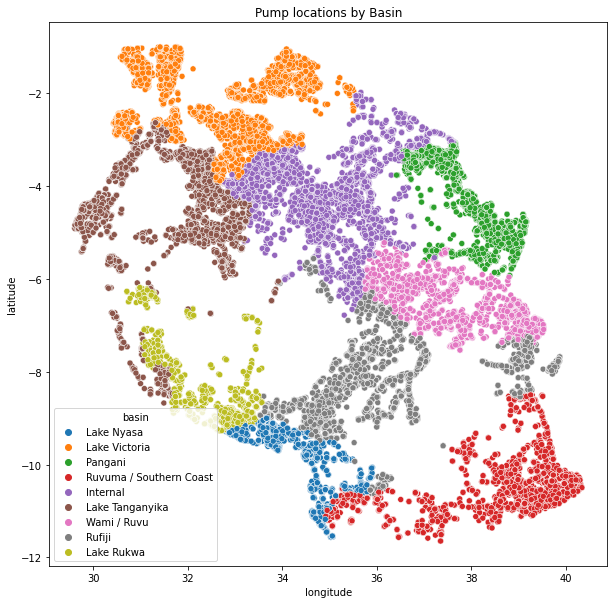

In [60]:
plt.figure(figsize=(10,10))

ax = sns.scatterplot(x=nonzero['longitude'], y=nonzero['latitude'], hue=nonzero['basin'])
ax.set_title('Pump locations by Basin');

### 2.3.10 region

In [61]:
cat_qr.loc[['region']]

Unique values  Missing Values  Missing %    Mode  Mode Freq  Mode %
region            21               0        0.0  Iringa       5294     8.9

In [62]:
region = dist_check(train, 'region')
region

# of pumps  % of all pumps  % functional  % non functional  \
region                                                                      
Iringa               5294             8.9          78.2              19.5   
Shinyanga            4982             8.4          56.0              31.3   
Mbeya                4639             7.8          50.0              39.1   
Kilimanjaro          4379             7.4          60.3              32.4   
Morogoro             4006             6.7          52.9              39.6   
Arusha               3350             5.6          68.5              26.3   
Kagera               3316             5.6          52.1              38.8   
Mwanza               3102             5.2          48.4              45.7   
Kigoma               2816             4.7          48.4              30.2   
Ruvuma               2640             4.4          56.1              37.7   
Pwani                2635             4.4          59.1              39.6   
Tanga                2547             4.3          56.4              40.8   
Dodoma               2201             3.7          45.8              44.7   
Singida              2093             3.5          48.3              45.6   
Mara                 1969             3.3          45.0              52.0   
Tabora               1959             3.3          43.3              54.4   
Rukwa                1808             3.0          39.1              53.4   
Mtwara               1730             2.9          30.3              62.4   
Manyara              1583             2.7          62.3              31.6   
Lindi                1546             2.6          29.8              64.2   
Dar es Salaam         805             1.4          57.3              42.4   

               % functional needs repair  
region                                    
Iringa                               2.3  
Shinyanga                           12.7  
Mbeya                               10.9  
Kilimanjaro                          7.4  
Morogoro                             7.5  
Arusha                               5.2  
Kagera                               9.2  
Mwanza                               5.9  
Kigoma                              21.4  
Ruvuma                               6.2  
Pwani                                1.4  
Tanga                                2.9  
Dodoma                               9.5  
Singida                              6.1  
Mara                                 3.0  
Tabora                               2.3  
Rukwa                                7.5  
Mtwara                               7.3  
Manyara                              6.1  
Lindi                                6.0  
Dar es Salaam                        0.4

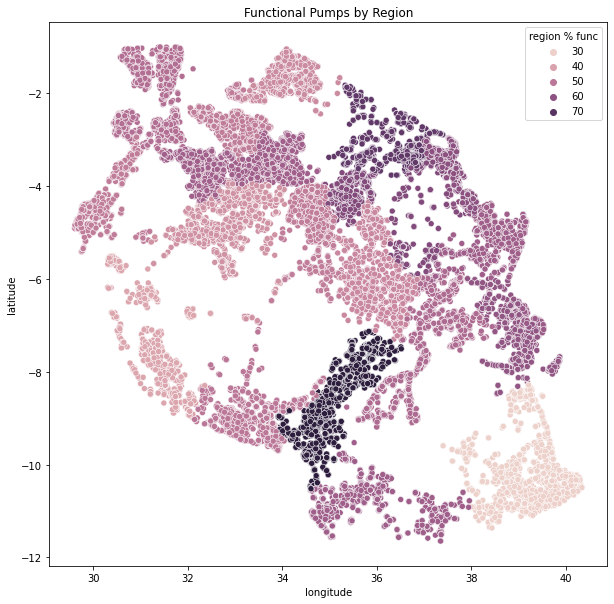

In [63]:
plt.figure(figsize=(10,10))

nonzero['region % func'] = nonzero['region'].apply(lambda x: region['% functional'].loc[x])
ax = sns.scatterplot(x=nonzero['longitude'], y=nonzero['latitude'], hue=nonzero['region % func'])
ax.set_title('Functional Pumps by Region');

### 2.3.11 region_code

In [64]:
cat_qr.loc[['region_code']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
region_code            27               0        0.0   11       5300     8.9

In [65]:
region_c = dist_check(train, 'region_code')
region_c

# of pumps  % of all pumps  % functional  % non functional  \
region_code                                                               
11                 5300             8.9          78.2              19.5   
17                 5011             8.4          56.0              31.3   
12                 4639             7.8          50.0              39.1   
3                  4379             7.4          60.3              32.4   
5                  4040             6.8          53.1              39.4   
18                 3324             5.6          52.0              38.8   
19                 3047             5.1          48.2              46.0   
2                  3024             5.1          65.4              28.8   
16                 2816             4.7          48.4              30.2   
10                 2640             4.4          56.1              37.7   
4                  2513             4.2          56.0              41.1   
1                  2201             3.7          45.8              44.7   
13                 2093             3.5          48.3              45.6   
14                 1979             3.3          43.6              54.1   
20                 1969             3.3          45.0              52.0   
15                 1808             3.0          39.1              53.4   
6                  1609             2.7          66.3              32.8   
21                 1583             2.7          62.3              31.6   
80                 1238             2.1          34.9              58.8   
60                 1025             1.7          47.8              50.2   
90                  917             1.5          21.2              68.2   
7                   805             1.4          57.3              42.4   
99                  423             0.7          45.2              53.2   
9                   390             0.7          35.6              59.0   
24                  326             0.5          96.9               2.8   
8                   300             0.5           8.7              86.3   
40                    1             0.0           0.0             100.0   

             % functional needs repair  
region_code                             
11                                 2.3  
17                                12.7  
12                                10.9  
3                                  7.4  
5                                  7.4  
18                                 9.1  
19                                 5.8  
2                                  5.8  
16                                21.4  
10                                 6.2  
4                                  2.9  
1                                  9.5  
13                                 6.1  
14                                 2.4  
20                                 3.0  
15                                 7.5  
6                                  1.0  
21                                 6.1  
80                                 6.3  
60                                 2.0  
90                                10.7  
7                                  0.4  
99                                 1.7  
9                                  5.4  
24                                 0.3  
8                                  5.0  
40                                 0.0

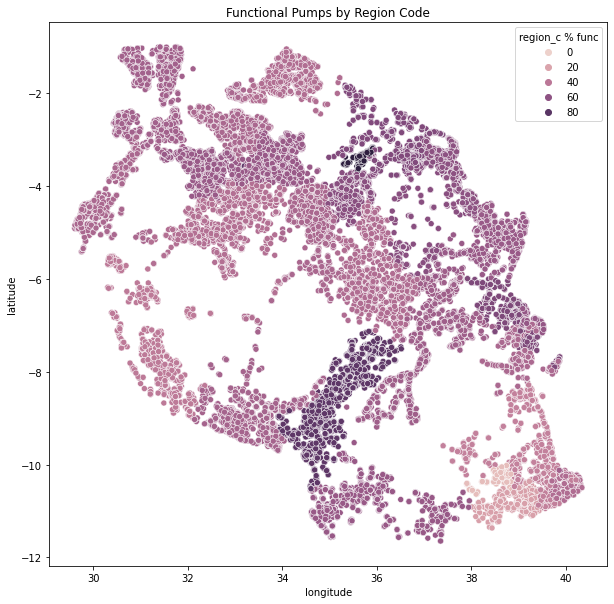

In [66]:
plt.figure(figsize=(10,10))

nonzero['region_c % func'] = nonzero['region_code'].apply(lambda x: region_c['% functional'].loc[x])
ax = sns.scatterplot(x=nonzero['longitude'], y=nonzero['latitude'], hue=nonzero['region_c % func'])
ax.set_title('Functional Pumps by Region Code');

In [67]:
# Since region and region_code are mostly aligned, the more granular region_code is likely to be more useful,
# as especially in the far southeast area, we see big differences in functionality within what is otherwise
# a solid block in the region plot.

### 2.3.12 district_code

In [68]:
cat_qr.loc[['district_code']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
district_code            20               0        0.0    1      12203    20.5

In [69]:
dist_check(train, 'district_code')

# of pumps  % of all pumps  % functional  % non functional  \
district_code                                                               
1                   12203            20.5          53.7              35.7   
2                   11173            18.8          55.5              36.9   
3                    9998            16.8          49.5              43.5   
4                    8999            15.1          62.2              32.2   
5                    4356             7.3          56.9              38.6   
6                    4074             6.9          50.4              43.9   
7                    3343             5.6          60.2              33.4   
8                    1043             1.8          56.5              38.4   
30                    995             1.7          69.2              22.1   
33                    874             1.5          22.2              66.6   
53                    745             1.3          33.6              63.0   
43                    505             0.9          42.2              56.2   
13                    391             0.7          30.4              62.1   
23                    293             0.5          56.3              34.8   
63                    195             0.3          31.8              65.6   
62                    109             0.2          52.3              47.7   
60                     63             0.1          81.0              14.3   
0                      23             0.0          17.4              73.9   
80                     12             0.0          25.0              66.7   
67                      6             0.0          83.3               0.0   

               % functional needs repair  
district_code                             
1                                   10.5  
2                                    7.6  
3                                    7.0  
4                                    5.7  
5                                    4.5  
6                                    5.7  
7                                    6.4  
8                                    5.1  
30                                   8.6  
33                                  11.2  
53                                   3.5  
43                                   1.6  
13                                   7.4  
23                                   8.9  
63                                   2.6  
62                                   0.0  
60                                   4.8  
0                                    8.7  
80                                   8.3  
67                                  16.7

In [70]:
district_code = train.groupby(['region', 'district_code'])['id'].count().reset_index()
district_code.head(20)

region  district_code    id
0          Arusha              1   189
1          Arusha              2  1206
2          Arusha              3   109
3          Arusha              5   201
4          Arusha              6   310
5          Arusha              7  1009
6          Arusha             30   326
7   Dar es Salaam              1    93
8   Dar es Salaam              2   497
9   Dar es Salaam              3   215
10         Dodoma              0    23
11         Dodoma              1   888
12         Dodoma              3   361
13         Dodoma              4   347
14         Dodoma              5   358
15         Dodoma              6   224
16         Iringa              1   728
17         Iringa              2   530
18         Iringa              3   650
19         Iringa              4  2473

In [71]:
# There is some cross-region properties to the district_code.
# Perhaps these features could be combined in some way.

### 2.3.13 lga

In [72]:
cat_qr.loc[['lga']]

Unique values  Missing Values  Missing %    Mode  Mode Freq  Mode %
lga           125               0        0.0  Njombe       2503     4.2

In [73]:
dist_check(train, 'lga')

# of pumps  % of all pumps  % functional  % non functional  \
lga                                                                        
Njombe              2503             4.2          80.2              16.1   
Arusha Rural        1252             2.1          69.9              26.3   
Moshi Rural         1251             2.1          58.6              31.9   
Bariadi             1177             2.0          49.3              16.0   
Rungwe              1106             1.9          61.1              24.3   
...                  ...             ...           ...               ...   
Moshi Urban           79             0.1          79.7              20.3   
Kigoma Urban          71             0.1          21.1              67.6   
Arusha Urban          63             0.1          66.7              22.2   
Lindi Urban           21             0.0          33.3              66.7   
Nyamagana              1             0.0           0.0             100.0   

              % functional needs repair  
lga                                      
Njombe                              3.8  
Arusha Rural                        3.8  
Moshi Rural                         9.5  
Bariadi                            34.7  
Rungwe                             14.6  
...                                 ...  
Moshi Urban                         0.0  
Kigoma Urban                       11.3  
Arusha Urban                       11.1  
Lindi Urban                         0.0  
Nyamagana                           0.0  

[125 rows x 5 columns]

In [74]:
lga = train.groupby(['region', 'lga'])['id'].count().reset_index()
lga.head(20)

region           lga    id
0          Arusha  Arusha Rural  1252
1          Arusha  Arusha Urban    63
2          Arusha        Karatu   326
3          Arusha       Longido   310
4          Arusha          Meru  1009
5          Arusha       Monduli   189
6          Arusha    Ngorongoro   201
7   Dar es Salaam         Ilala   497
8   Dar es Salaam     Kinondoni    93
9   Dar es Salaam        Temeke   215
10         Dodoma          Bahi   224
11         Dodoma      Chamwino   347
12         Dodoma  Dodoma Urban   358
13         Dodoma        Kondoa   523
14         Dodoma        Kongwa   361
15         Dodoma       Mpwapwa   388
16         Iringa  Iringa Rural   728
17         Iringa        Kilolo   349
18         Iringa        Ludewa   564
19         Iringa        Makete   630

In [75]:
# Similar to district_code, each region has multiple lga's.
# However these are unique, and are merely subsets of regions.

### 2.3.14 ward

In [76]:
cat_qr.loc[['ward']]

Unique values  Missing Values  Missing %   Mode  Mode Freq  Mode %
ward          2092               0        0.0  Igosi        307     0.5

In [77]:
dist_check(train, 'ward')

# of pumps  % of all pumps  % functional  % non functional  \
ward                                                                    
Igosi             307             0.5          94.1               5.9   
Imalinyi          252             0.4          95.2               3.6   
Siha Kati         232             0.4          98.3               0.9   
Mdandu            231             0.4          87.4               6.9   
Nduruma           217             0.4          63.1              29.5   
...               ...             ...           ...               ...   
Kitete              1             0.0         100.0               0.0   
Mitole              1             0.0           0.0             100.0   
Themi               1             0.0           0.0             100.0   
Thawi               1             0.0           0.0             100.0   
Igogo               1             0.0           0.0             100.0   

           % functional needs repair  
ward                                  
Igosi                            0.0  
Imalinyi                         1.2  
Siha Kati                        0.9  
Mdandu                           5.6  
Nduruma                          7.4  
...                              ...  
Kitete                           0.0  
Mitole                           0.0  
Themi                            0.0  
Thawi                            0.0  
Igogo                            0.0  

[2092 rows x 5 columns]

In [78]:
ward = train.groupby(['region', 'ward'])['id'].count().reset_index()
ward.sort_values('id', ascending=0).head(20)

region           ward   id
251          Iringa          Igosi  307
263          Iringa       Imalinyi  252
665     Kilimanjaro      Siha Kati  232
316          Iringa         Mdandu  231
57           Arusha        Nduruma  205
1556          Rukwa        Mishamo  203
1441          Pwani       Chalinze  196
103   Dar es Salaam        Kitunda  195
36           Arusha   Maji ya Chai  190
342          Iringa          Usuka  187
1653         Ruvuma         Msindo  182
58           Arusha   Ngarenanyuki  172
1509          Pwani        Vikindu  162
96    Dar es Salaam        Chanika  154
326          Iringa        Mtwango  153
312          Iringa         Matola  145
1513          Pwani  Zinga/Ikerege  141
345          Iringa   Wanging'ombe  139
2104          Tanga        Maramba  139
1469          Pwani       Magomeni  135

In [79]:
# A further subdivision of location, again these are unique. Much higher cardinality (> 2000 unique values)

### 2.3.15 subvillage

In [80]:
cat_qr.loc[['subvillage']]

Unique values  Missing Values  Missing %      Mode  Mode Freq  \
subvillage         19287             371        0.6  Madukani        508   

            Mode %  
subvillage     0.9

In [81]:
dist_check(train, 'subvillage')

# of pumps  % of all pumps  % functional  % non functional  \
subvillage                                                                     
Madukani                 508             0.9          48.8              42.7   
Shuleni                  506             0.9          45.7              45.7   
Majengo                  502             0.8          46.6              46.2   
Kati                     373             0.6          57.6              30.8   
Mtakuja                  262             0.4          54.2              40.5   
...                      ...             ...           ...               ...   
Lwenge`A'                  1             0.0           0.0             100.0   
Lwengera Darajan           1             0.0         100.0               0.0   
Lwiche                     1             0.0         100.0               0.0   
Lwihomelo                  1             0.0         100.0               0.0   
Zuri                       1             0.0           0.0             100.0   

                  % functional needs repair  
subvillage                                   
Madukani                                8.5  
Shuleni                                 8.7  
Majengo                                 7.2  
Kati                                   11.5  
Mtakuja                                 5.3  
...                                     ...  
Lwenge`A'                               0.0  
Lwengera Darajan                        0.0  
Lwiche                                  0.0  
Lwihomelo                               0.0  
Zuri                                    0.0  

[19287 rows x 5 columns]

In [82]:
subvillage = train.groupby(['region', 'subvillage'])['id'].count().reset_index()
subvillage.sort_values('id', ascending=0).head(20)

region            subvillage   id
2320          Iringa                     M  187
12767         Mwanza                     1  132
2036          Iringa                  Kati  123
11950       Morogoro               Shuleni  112
1752          Iringa                     I  109
17984      Shinyanga              Madukani  106
353           Arusha              Madukani  102
897    Dar es Salaam  Mtaa Wa Kitunda Kati   84
2022          Iringa                     K   74
2566          Iringa              Mjimwema   70
2379          Iringa               Majengo   63
22367          Tanga                Sokoni   60
898    Dar es Salaam        Mtaa Wa Kivule   59
407           Arusha         Marurani Kati   59
189           Arusha                  Kati   54
1201          Dodoma                Kawawa   54
406           Arusha          Marurani Juu   54
13439         Mwanza              Madukani   52
2665          Iringa               Mtakuja   51
9232            Mara                 Senta   51

In [83]:
# A final subdivision. However these are not necessarily unique
# (multiple villages with the same name in different regions)

### 2.3.16 population

In [84]:
display_num_qr('population')

count    59400.0
mean       179.9
std        471.5
min          0.0
25%          0.0
50%         25.0
75%        215.0
max      30500.0
Name: population, dtype: float64

Unique Values
population          1049

<AxesSubplot:xlabel='population', ylabel='Density'>

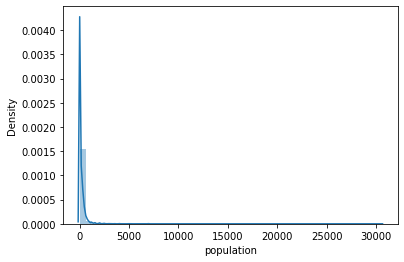

In [85]:
sns.distplot(train['population'])

In [86]:
popul = train.groupby(['population'])['id'].count().reset_index()
popul.sort_values('id', ascending=0).head(20)

population     id
0             0  21381
1             1   7025
197         200   1940
149         150   1892
247         250   1681
296         300   1476
100         100   1146
50           50   1139
466         500   1009
343         350    986
120         120    916
384         400    775
60           60    706
30           30    626
40           40    552
80           80    533
426         450    499
20           20    462
552         600    438
227         230    388

In [87]:
dist_check(train, 'population').head(10)

# of pumps  % of all pumps  % functional  % non functional  \
population                                                               
0                21381            36.0          52.7              39.0   
1                 7025            11.8          41.4              53.5   
200               1940             3.3          58.7              36.3   
150               1892             3.2          62.5              31.8   
250               1681             2.8          46.0              48.5   
300               1476             2.5          52.5              41.9   
100               1146             1.9          60.6              34.0   
50                1139             1.9          65.1              29.0   
500               1009             1.7          48.6              40.7   
350                986             1.7          53.3              39.1   

            % functional needs repair  
population                             
0                                 8.3  
1                                 5.0  
200                               5.0  
150                               5.7  
250                               5.5  
300                               5.6  
100                               5.4  
50                                5.9  
500                              10.7  
350                               7.5

In [88]:
# Population is interesting - over a third are listed at 0, and 12% at only 1!
# As well, there are quite a few with populations of very round numbers, 200/150/250,
# so this is likely a very messy feature. Perhaps this could be engineered or binned in some way.

### 2.3.17 permit

In [89]:
cat_qr.loc[['permit']]

Unique values  Missing Values  Missing %  Mode  Mode Freq  Mode %
permit             2            3056        5.1  True      38852    65.4

In [90]:
dist_check(train, 'permit')

# of pumps  % of all pumps  % functional  % non functional  \
permit                                                               
True         38852            65.4          55.4              37.6   
False        17492            29.4          51.7              40.7   

        % functional needs repair  
permit                             
True                          6.9  
False                         7.5

### 2.3.18 public_meeting

In [91]:
cat_qr.loc[['public_meeting']]

Unique values  Missing Values  Missing %  Mode  Mode Freq  \
public_meeting             2            3334        5.6  True      51011   

                Mode %  
public_meeting    85.9

In [92]:
dist_check(train, 'public_meeting')

# of pumps  % of all pumps  % functional  % non functional  \
public_meeting                                                               
True                 51011            85.9          55.7              37.0   
False                 5055             8.5          43.0              48.3   

                % functional needs repair  
public_meeting                             
True                                  7.3  
False                                 8.7

In [93]:
# Permit, but to a lesser extent public_meeting, seem to not weigh very heavily on functionality.
# public_meeting might be more useful, but there are a fair number of missing values
# (roughly similar % missing in both features)

### 2.3.19 construction_year

In [94]:
display_num_qr('construction_year')

count    59400.0
mean      1300.7
std        951.6
min          0.0
25%          0.0
50%       1986.0
75%       2004.0
max       2013.0
Name: construction_year, dtype: float64

Unique Values
construction_year            55

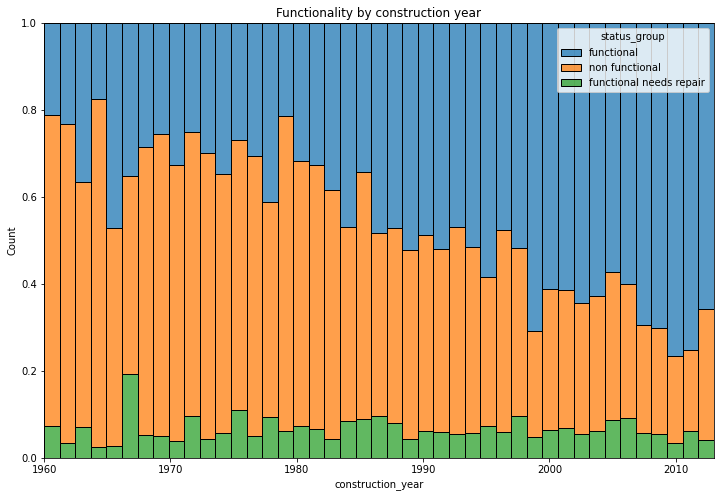

In [95]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train[train['construction_year']!=0],
            x='construction_year', hue='status_group', multiple='fill')
ax.set_title('Functionality by construction year');

In [96]:
# The bottom quartile has an imputed '0' value, but otherwise the years strongly correlate with
# higher functionality.

In [97]:
train['construction_year'] = np.where(x_train['construction_year']==0.0, np.nan, x_train['construction_year'])
train['construction_year'] = train['construction_year'].astype('float64')

X['construction_year'] = np.where(X['construction_year']==0.0, np.nan, X['construction_year'])
X['construction_year'] = X['construction_year'].astype('float64')

train['construction_year'].head()

0    1999.0
1    2010.0
2    2009.0
3    1986.0
4       NaN
Name: construction_year, dtype: float64

### 2.3.20  extraction_type_class / extraction_type_group / extraction_type

In [98]:
cat_qr.loc[['extraction_type_class']]

Unique values  Missing Values  Missing %     Mode  \
extraction_type_class             7               0        0.0  gravity   

                       Mode Freq  Mode %  
extraction_type_class      26780    45.1

In [99]:
dist_check(train, 'extraction_type_class')

# of pumps  % of all pumps  % functional  \
extraction_type_class                                             
gravity                     26780            45.1          59.9   
handpump                    16456            27.7          63.0   
other                        6430            10.8          16.0   
submersible                  6179            10.4          53.9   
motorpump                    2987             5.0          38.0   
rope pump                     451             0.8          65.0   
wind-powered                  117             0.2          42.7   

                       % non functional  % functional needs repair  
extraction_type_class                                               
gravity                            30.0                       10.1  
handpump                           30.9                        6.0  
other                              80.8                        3.2  
submersible                        42.0                        4.1  
motorpump                          57.4                        4.6  
rope pump                          31.3                        3.8  
wind-powered                       51.3                        6.0

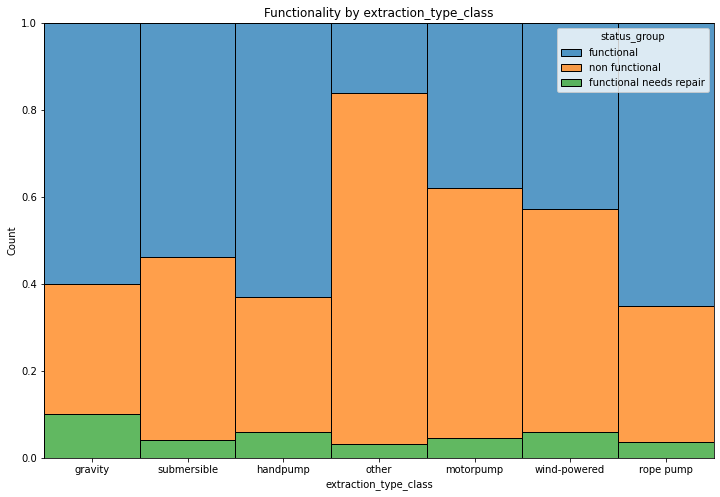

In [100]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train,
            x='extraction_type_class', hue='status_group', multiple='fill')
ax.set_title('Functionality by extraction_type_class');

In [101]:
cat_qr.loc[['extraction_type_group']]

Unique values  Missing Values  Missing %     Mode  \
extraction_type_group            13               0        0.0  gravity   

                       Mode Freq  Mode %  
extraction_type_group      26780    45.1

In [102]:
dist_check(train, 'extraction_type_group')

# of pumps  % of all pumps  % functional  \
extraction_type_group                                             
gravity                     26780            45.1          59.9   
nira/tanira                  8154            13.7          66.5   
other                        6430            10.8          16.0   
submersible                  6179            10.4          53.9   
swn 80                       3670             6.2          56.9   
mono                         2865             4.8          37.8   
india mark ii                2400             4.0          60.3   
afridev                      1770             3.0          67.8   
rope pump                     451             0.8          65.0   
other handpump                364             0.6          47.3   
other motorpump               122             0.2          43.4   
wind-powered                  117             0.2          42.7   
india mark iii                 98             0.2          44.9   

                       % non functional  % functional needs repair  
extraction_type_group                                               
gravity                            30.0                       10.1  
nira/tanira                        25.7                        7.9  
other                              80.8                        3.2  
submersible                        42.0                        4.1  
swn 80                             37.3                        5.8  
mono                               57.7                        4.5  
india mark ii                      36.4                        3.3  
afridev                            29.8                        2.4  
rope pump                          31.3                        3.8  
other handpump                     47.3                        5.5  
other motorpump                    49.2                        7.4  
wind-powered                       51.3                        6.0  
india mark iii                     54.1                        1.0

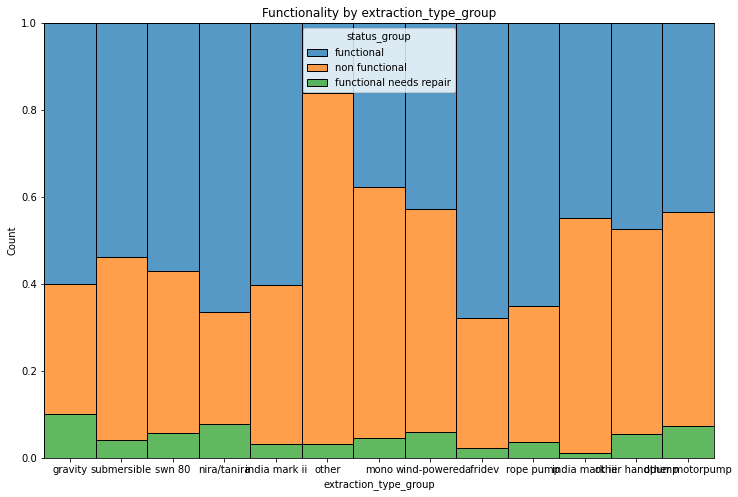

In [103]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train,
            x='extraction_type_group', hue='status_group', multiple='fill')
ax.set_title('Functionality by extraction_type_group');

In [104]:
cat_qr.loc[['extraction_type']]

Unique values  Missing Values  Missing %     Mode  Mode Freq  \
extraction_type            18               0        0.0  gravity      26780   

                 Mode %  
extraction_type    45.1

In [105]:
dist_check(train, 'extraction_type')

# of pumps  % of all pumps  % functional  \
extraction_type                                                       
gravity                         26780            45.1          59.9   
nira/tanira                      8154            13.7          66.5   
other                            6430            10.8          16.0   
submersible                      4764             8.0          55.1   
swn 80                           3670             6.2          56.9   
mono                             2865             4.8          37.8   
india mark ii                    2400             4.0          60.3   
afridev                          1770             3.0          67.8   
ksb                              1415             2.4          49.7   
other - rope pump                 451             0.8          65.0   
other - swn 81                    229             0.4          52.4   
windmill                          117             0.2          42.7   
india mark iii                     98             0.2          44.9   
cemo                               90             0.2          50.0   
other - play pump                  85             0.1          34.1   
walimi                             48             0.1          47.9   
climax                             32             0.1          25.0   
other - mkulima/shinyanga           2             0.0           0.0   

                           % non functional  % functional needs repair  
extraction_type                                                         
gravity                                30.0                       10.1  
nira/tanira                            25.7                        7.9  
other                                  80.8                        3.2  
submersible                            40.1                        4.8  
swn 80                                 37.3                        5.8  
mono                                   57.7                        4.5  
india mark ii                          36.4                        3.3  
afridev                                29.8                        2.4  
ksb                                    48.5                        1.8  
other - rope pump                      31.3                        3.8  
other - swn 81                         44.5                        3.1  
windmill                               51.3                        6.0  
india mark iii                         54.1                        1.0  
cemo                                   40.0                       10.0  
other - play pump                      64.7                        1.2  
walimi                                 27.1                       25.0  
climax                                 75.0                        0.0  
other - mkulima/shinyanga             100.0                        0.0

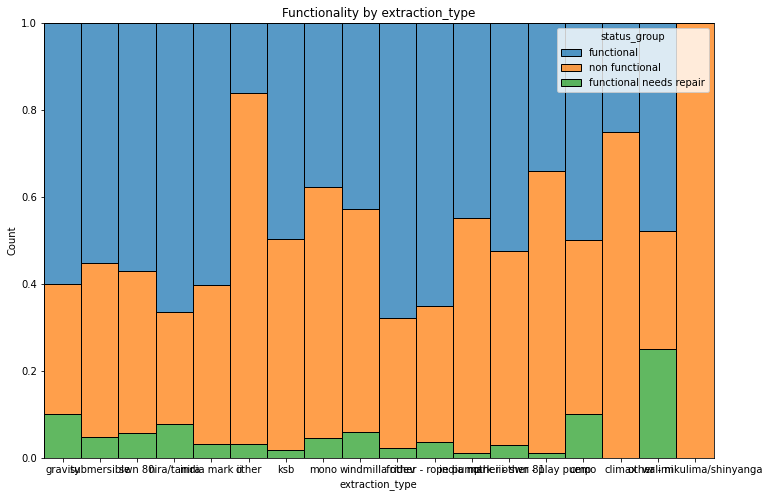

In [106]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train,
            x='extraction_type', hue='status_group', multiple='fill')
ax.set_title('Functionality by extraction_type');

In [107]:
# As we go from less to more granularity in extraction_type, there certainly seems
# to be more useful data. However we do have types with very few pumps.
# Grouping them up when possible would likely be best.

### 2.3.21 recorded_by

In [108]:
cat_qr.loc[['recorded_by']]

Unique values  Missing Values  Missing %                     Mode  \
recorded_by             1               0        0.0  GeoData Consultants Ltd   

             Mode Freq  Mode %  
recorded_by      59400   100.0

In [109]:
# Not sure why I missed this earlier, but there is one value here
# and thus no useful information.

In [110]:
train = train.drop(['recorded_by'], axis=1)
X = X.drop(['recorded_by'], axis=1)

### 2.3.22 management_group / scheme_management / management

In [111]:
cat_qr.loc[['management_group']]

Unique values  Missing Values  Missing %        Mode  \
management_group             5               0        0.0  user-group   

                  Mode Freq  Mode %  
management_group      52490    88.4

In [112]:
dist_check(train, 'management_group')

# of pumps  % of all pumps  % functional  % non functional  \
management_group                                                               
user-group             52490            88.4          53.8              38.7   
commercial              3638             6.1          61.4              35.3   
parastatal              1768             3.0          57.7              30.4   
other                    943             1.6          56.0              38.1   
unknown                  561             0.9          39.9              55.3   

                  % functional needs repair  
management_group                             
user-group                              7.4  
commercial                              3.2  
parastatal                             11.9  
other                                   5.9  
unknown                                 4.8

In [113]:
cat_qr.loc[['scheme_management']]

Unique values  Missing Values  Missing % Mode  Mode Freq  \
scheme_management            12            3877        6.5  VWC      36793   

                   Mode %  
scheme_management    61.9

In [114]:
dist_check(train, 'scheme_management')

# of pumps  % of all pumps  % functional  % non functional  \
scheme_management                                                               
VWC                     36793            61.9          51.5              42.1   
WUG                      5206             8.8          57.7              29.4   
Water authority          3153             5.3          51.3              34.5   
WUA                      2883             4.9          69.2              22.5   
Water Board              2748             4.6          74.7              21.3   
Parastatal               1680             2.8          57.5              30.5   
Private operator         1063             1.8          68.6              29.3   
Company                  1061             1.8          50.3              46.2   
Other                     766             1.3          59.8              37.3   
SWC                        97             0.2          20.6              78.4   
Trust                      72             0.1          63.9              29.2   
None                        1             0.0         100.0               0.0   

                   % functional needs repair  
scheme_management                             
VWC                                      6.3  
WUG                                     12.9  
Water authority                         14.2  
WUA                                      8.3  
Water Board                              4.0  
Parastatal                              12.0  
Private operator                         2.2  
Company                                  3.5  
Other                                    2.9  
SWC                                      1.0  
Trust                                    6.9  
None                                     0.0

In [115]:
cat_qr.loc[['management']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
management            12               0        0.0  vwc      40507    68.2

In [116]:
dist_check(train, 'management')

# of pumps  % of all pumps  % functional  % non functional  \
management                                                                     
vwc                    40507            68.2          50.4              42.7   
wug                     6515            11.0          60.0              30.1   
water board             2933             4.9          74.0              17.0   
wua                     2535             4.3          69.1              22.8   
private operator        1971             3.3          74.9              22.9   
parastatal              1768             3.0          57.7              30.4   
water authority          904             1.5          49.3              44.9   
other                    844             1.4          59.8              33.6   
company                  685             1.2          39.0              58.8   
unknown                  561             0.9          39.9              55.3   
other - school            99             0.2          23.2              75.8   
trust                     78             0.1          59.0              33.3   

                  % functional needs repair  
management                                   
vwc                                     6.9  
wug                                     9.9  
water board                             9.0  
wua                                     8.1  
private operator                        2.2  
parastatal                             11.9  
water authority                         5.8  
other                                   6.5  
company                                 2.2  
unknown                                 4.8  
other - school                          1.0  
trust                                   7.7

In [117]:
# It's not clear how exactly the two more granular features relate - ultimately I'll
# have to just pick one or the other, likely the 'management' feature

### 2.3.23 scheme_name

In [118]:
cat_qr.loc[['scheme_name']]

Unique values  Missing Values  Missing % Mode  Mode Freq  Mode %
scheme_name          2696           28166       47.4    K        682     1.1

In [119]:
dist_check(train, 'scheme_name')

# of pumps  % of all pumps  % functional  \
scheme_name                                                                 
K                                       682             1.1          55.1   
None                                    644             1.1          64.0   
Borehole                                546             0.9          37.4   
Chalinze wate                           405             0.7          85.9   
M                                       400             0.7          49.2   
...                                     ...             ...           ...   
Igongolo gravity water sch                1             0.0         100.0   
Bwawa                                     1             0.0           0.0   
Oonjorai pipelines                        1             0.0           0.0   
Maga                                      1             0.0         100.0   
Njalamatatawater gravity scheme           1             0.0         100.0   

                                 % non functional  % functional needs repair  
scheme_name                                                                   
K                                            28.0                       16.9  
None                                         31.4                        4.7  
Borehole                                     57.9                        4.8  
Chalinze wate                                14.1                        0.0  
M                                            36.8                       14.0  
...                                           ...                        ...  
Igongolo gravity water sch                    0.0                        0.0  
Bwawa                                       100.0                        0.0  
Oonjorai pipelines                            0.0                      100.0  
Maga                                          0.0                        0.0  
Njalamatatawater gravity scheme               0.0                        0.0  

[2696 rows x 5 columns]

In [120]:
# High cardinality and very high missing values means this is likely not a useful feature

In [121]:
train = train.drop(['scheme_name'], axis=1)

In [122]:
X = X.drop(['scheme_name'], axis=1)

### 2.3.24 payment

In [123]:
cat_qr.loc[['payment']]

Unique values  Missing Values  Missing %       Mode  Mode Freq  Mode %
payment             7               0        0.0  never pay      25348    42.7

In [124]:
dist_check(train, 'payment')

# of pumps  % of all pumps  % functional  \
payment                                                           
never pay                   25348            42.7          44.9   
pay per bucket               8985            15.1          67.8   
pay monthly                  8300            14.0          66.0   
unknown                      8157            13.7          43.3   
pay when scheme fails        3914             6.6          62.1   
pay annually                 3642             6.1          75.2   
other                        1054             1.8          58.0   

                       % non functional  % functional needs repair  
payment                                                             
never pay                          47.6                        7.5  
pay per bucket                     27.7                        4.6  
pay monthly                        22.8                       11.2  
unknown                            51.5                        5.3  
pay when scheme fails              30.9                        7.1  
pay annually                       18.0                        6.8  
other                              30.8                       11.2

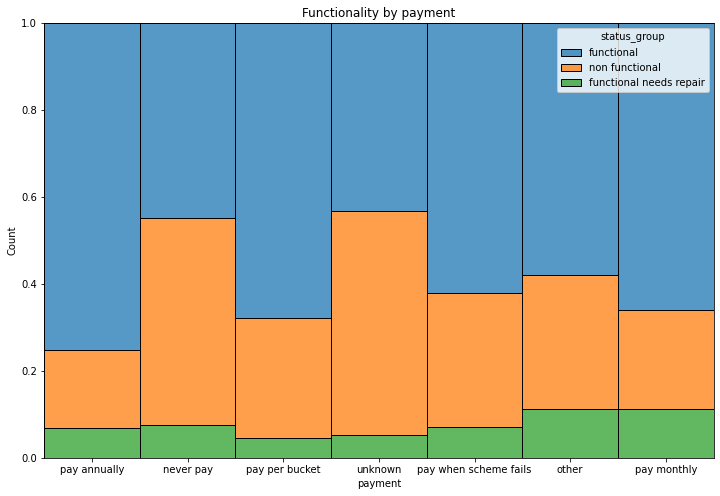

In [125]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train,
            x='payment', hue='status_group', multiple='fill')
ax.set_title('Functionality by payment');

In [126]:
# there certainly seems to be marked differences in 'never pay'/'unknown' and all others

### 2.3.25 quality_group / water_quality

In [127]:
cat_qr.loc[['quality_group']]

Unique values  Missing Values  Missing %  Mode  Mode Freq  \
quality_group             6               0        0.0  good      50818   

               Mode %  
quality_group    85.6

In [128]:
dist_check(train, 'quality_group')

# of pumps  % of all pumps  % functional  % non functional  \
quality_group                                                               
good                50818            85.6          56.6              35.7   
salty                5195             8.7          46.1              48.2   
unknown              1876             3.2          14.1              84.1   
milky                 804             1.4          54.5              43.8   
colored               490             0.8          50.2              38.8   
fluoride              217             0.4          72.4              21.7   

               % functional needs repair  
quality_group                             
good                                 7.7  
salty                                5.7  
unknown                              1.9  
milky                                1.7  
colored                             11.0  
fluoride                             6.0

In [129]:
cat_qr.loc[['water_quality']]

Unique values  Missing Values  Missing %  Mode  Mode Freq  \
water_quality             8               0        0.0  soft      50818   

               Mode %  
water_quality    85.6

In [130]:
dist_check(train, 'water_quality')

# of pumps  % of all pumps  % functional  \
water_quality                                                  
soft                     50818            85.6          56.6   
salty                     4856             8.2          45.7   
unknown                   1876             3.2          14.1   
milky                      804             1.4          54.5   
coloured                   490             0.8          50.2   
salty abandoned            339             0.6          51.3   
fluoride                   200             0.3          75.5   
fluoride abandoned          17             0.0          35.3   

                    % non functional  % functional needs repair  
water_quality                                                    
soft                            35.7                        7.7  
salty                           49.6                        4.6  
unknown                         84.1                        1.9  
milky                           43.8                        1.7  
coloured                        38.8                       11.0  
salty abandoned                 27.4                       21.2  
fluoride                        18.0                        6.5  
fluoride abandoned              64.7                        0.0

In [131]:
# Very similar, except 'salty' and 'flouride' are further subdivided into regular and
# abandoned versions. I'll just keep the more granular version.

In [132]:
train = train.drop(['quality_group'], axis=1)

In [133]:
X = X.drop(['quality_group'], axis=1)

### 2.3.26 quantity

In [134]:
cat_qr.loc[['quantity']]

Unique values  Missing Values  Missing %    Mode  Mode Freq  Mode %
quantity             5               0        0.0  enough      33186    55.9

In [135]:
dist_check(train, 'quantity')

# of pumps  % of all pumps  % functional  % non functional  \
quantity                                                                   
enough             33186            55.9          65.2              27.5   
insufficient       15129            25.5          52.3              38.1   
dry                 6246            10.5           2.5              96.9   
seasonal            4050             6.8          57.4              32.3   
unknown              789             1.3          27.0              71.2   

              % functional needs repair  
quantity                                 
enough                              7.2  
insufficient                        9.6  
dry                                 0.6  
seasonal                           10.3  
unknown                             1.8

In [136]:
# Seems like a good feature - dry and unknown are much more likely to be non-functional

### 2.3.27 source_class / source_type / source

In [137]:
cat_qr.loc[['source_class']]

Unique values  Missing Values  Missing %         Mode  Mode Freq  \
source_class             3               0        0.0  groundwater      45794   

              Mode %  
source_class    77.1

In [138]:
dist_check(train, 'source_class')

# of pumps  % of all pumps  % functional  % non functional  \
source_class                                                               
groundwater        45794            77.1          54.2              39.8   
surface            13328            22.4          54.5              33.7   
unknown              278             0.5          56.8              41.4   

              % functional needs repair  
source_class                             
groundwater                         6.0  
surface                            11.8  
unknown                             1.8

In [139]:
cat_qr.loc[['source_type']]

Unique values  Missing Values  Missing %    Mode  Mode Freq  \
source_type             7               0        0.0  spring      17021   

             Mode %  
source_type    28.7

In [140]:
dist_check(train, 'source_type')

# of pumps  % of all pumps  % functional  \
source_type                                                      
spring                     17021            28.7          62.2   
shallow well               16824            28.3          49.5   
borehole                   11949            20.1          49.5   
river/lake                 10377            17.5          54.2   
rainwater harvesting        2295             3.9          60.4   
dam                          656             1.1          38.6   
other                        278             0.5          56.8   

                      % non functional  % functional needs repair  
source_type                                                        
spring                            30.3                        7.5  
shallow well                      44.8                        5.7  
borehole                          46.2                        4.3  
river/lake                        33.9                       11.9  
rainwater harvesting              25.9                       13.7  
dam                               57.8                        3.7  
other                             41.4                        1.8

In [141]:
cat_qr.loc[['source']]

Unique values  Missing Values  Missing %    Mode  Mode Freq  Mode %
source            10               0        0.0  spring      17021    28.7

In [142]:
dist_check(train, 'source')

# of pumps  % of all pumps  % functional  \
source                                                           
spring                     17021            28.7          62.2   
shallow well               16824            28.3          49.5   
machine dbh                11075            18.6          49.0   
river                       9612            16.2          56.9   
rainwater harvesting        2295             3.9          60.4   
hand dtw                     874             1.5          56.9   
lake                         765             1.3          21.2   
dam                          656             1.1          38.6   
other                        212             0.4          59.4   
unknown                       66             0.1          48.5   

                      % non functional  % functional needs repair  
source                                                             
spring                            30.3                        7.5  
shallow well                      44.8                        5.7  
machine dbh                       46.6                        4.4  
river                             30.4                       12.7  
rainwater harvesting              25.9                       13.7  
hand dtw                          41.2                        1.9  
lake                              77.3                        1.6  
dam                               57.8                        3.7  
other                             40.1                        0.5  
unknown                           45.5                        6.1

In [143]:
# This is nice and clean, I'll likely keep the most granular 'source' feature

In [144]:
# The additional classes seem to be varied in their functionality

### 2.3.28 waterpoint_type_group / waterpoint_type

In [145]:
cat_qr.loc[['waterpoint_type_group']]

Unique values  Missing Values  Missing %  \
waterpoint_type_group             6               0        0.0   

                                     Mode  Mode Freq  Mode %  
waterpoint_type_group  communal standpipe      34625    58.3

In [146]:
dist_check(train, 'waterpoint_type_group')

# of pumps  % of all pumps  % functional  \
waterpoint_type_group                                             
communal standpipe          34625            58.3          57.6   
hand pump                   17488            29.4          61.8   
other                        6380            10.7          13.2   
improved spring               784             1.3          71.8   
cattle trough                 116             0.2          72.4   
dam                             7             0.0          85.7   

                       % non functional  % functional needs repair  
waterpoint_type_group                                               
communal standpipe                 34.0                        8.4  
hand pump                          32.3                        5.9  
other                              82.2                        4.6  
improved spring                    17.3                       10.8  
cattle trough                      25.9                        1.7  
dam                                14.3                        0.0

In [147]:
cat_qr.loc[['waterpoint_type']]

Unique values  Missing Values  Missing %                Mode  \
waterpoint_type             7               0        0.0  communal standpipe   

                 Mode Freq  Mode %  
waterpoint_type      28522    48.0

In [148]:
dist_check(train, 'waterpoint_type')

# of pumps  % of all pumps  % functional  \
waterpoint_type                                                         
communal standpipe                28522            48.0          62.1   
hand pump                         17488            29.4          61.8   
other                              6380            10.7          13.2   
communal standpipe multiple        6103            10.3          36.6   
improved spring                     784             1.3          71.8   
cattle trough                       116             0.2          72.4   
dam                                   7             0.0          85.7   

                             % non functional  % functional needs repair  
waterpoint_type                                                           
communal standpipe                       29.9                        7.9  
hand pump                                32.3                        5.9  
other                                    82.2                        4.6  
communal standpipe multiple              52.8                       10.6  
improved spring                          17.3                       10.8  
cattle trough                            25.9                        1.7  
dam                                      14.3                        0.0

In [149]:
# the 'waterpoint_type' just splits up communal standpipe into two subclasses,
# which are very different in functionality, so I'll likely keep this one.

In [150]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  object        
 1   amount_tsh             59400 non-null  float64       
 2   date_recorded          59400 non-null  datetime64[ns]
 3   funder                 55765 non-null  object        
 4   gps_height             38962 non-null  float64       
 5   installer              55745 non-null  object        
 6   longitude              59400 non-null  float64       
 7   latitude               59400 non-null  float64       
 8   wpt_name               59400 non-null  object        
 9   num_private            59400 non-null  object        
 10  basin                  59400 non-null  object        
 11  subvillage             59029 non-null  object        
 12  region                 59400 non-null  object        
 13  r

<a id="clean"></a>
# 3. Data Cleaning
[Back to Top](#contents) | [Previous Section](#eda) | [Next Section](#model)

## 3.1 Missing Data / Simple Feature Engineering

In [151]:
(((train.isna().sum())/len(train))*100).sort_values().tail(9)

subvillage            0.624579
permit                5.144781
public_meeting        5.612795
funder                6.119529
installer             6.153199
scheme_management     6.526936
gps_height           34.407407
construction_year    34.863636
amount_tsh_imp       70.099327
dtype: float64

### 3.1.1 subvillage

In [155]:
nones = ['unknown', 'none', 'Unknown', 'None']
train[train['subvillage'].isin(nones)].subvillage

Series([], Name: subvillage, dtype: object)

In [156]:
temp = train.copy()
temp['subvillage'] = temp['subvillage'].fillna('unknown')
dist_check(temp, 'subvillage')

# of pumps  % of all pumps  % functional  % non functional  \
subvillage                                                               
Madukani           508             0.9          48.8              42.7   
Shuleni            506             0.9          45.7              45.7   
Majengo            502             0.8          46.6              46.2   
Kati               373             0.6          57.6              30.8   
unknown            371             0.6          55.3              44.5   
...                ...             ...           ...               ...   
Mbika A              1             0.0           0.0             100.0   
Mbika B              1             0.0           0.0             100.0   
Mbikija              1             0.0         100.0               0.0   
Mbikirija            1             0.0         100.0               0.0   
##                   1             0.0         100.0               0.0   

            % functional needs repair  
subvillage                             
Madukani                          8.5  
Shuleni                           8.7  
Majengo                           7.2  
Kati                             11.5  
unknown                           0.3  
...                               ...  
Mbika A                           0.0  
Mbika B                           0.0  
Mbikija                           0.0  
Mbikirija                         0.0  
##                                0.0  

[19288 rows x 5 columns]

In [157]:
# Imputing NaN subvillages with 'unknown' seems to be the best option, as they still
# have all other levels of granularity of region/ward/etc

In [158]:
train['subvillage'] = train['subvillage'].fillna('unknown')

In [159]:
X['subvillage'] = X['subvillage'].fillna('unknown')

### 3.1.2 Permit

In [160]:
# I'll impute based on mode, but according to lga, and then region for any stragglers

In [161]:
lga_df = train.copy()

# Create df with modes of region->lga
permit_mode_lga = lga_df.groupby(['region','lga'])['permit'].agg(pd.Series.mode).reset_index()
permit_mode_lga = permit_mode_lga.rename(columns={'permit':'permit_imp_lga'})

# df with modes of regions
permit_mode_region = lga_df.groupby(['region'])['permit'].agg(pd.Series.mode).reset_index()
permit_mode_region = permit_mode_region.rename(columns={'permit':'permit_imp_region'})

# Merge them with train/X df's
train = train.merge(permit_mode_lga, how='left', on=['region', 'lga'])
train = train.merge(permit_mode_region, how='left', on=['region'])

X = X.merge(permit_mode_lga, how='left', on=['region', 'lga'])
X = X.merge(permit_mode_region, how='left', on=['region'])

# Create 'permit_imp' feature by imputing from modes, first with lga, then region
train['permit_imp'] = np.where(train['permit'].isna(), train['permit_imp_lga'], train['permit'])
X['permit_imp'] = np.where(X['permit'].isna(), X['permit_imp_lga'], X['permit'])

train['permit_imp'] = np.where(train['permit'].isna(), train['permit_imp_region'], train['permit'])
X['permit_imp'] = np.where(X['permit'].isna(), X['permit_imp_region'], X['permit'])

# Drop extraneous features
train = train.drop(['permit', 'permit_imp_lga', 'permit_imp_region'], axis=1)
X = X.drop(['permit', 'permit_imp_lga', 'permit_imp_region'], axis=1)

In [162]:
# And I'll encode them as 0 or 1:

train['permit_imp'] = np.where(train['permit_imp']=='True', 1, 0)
X['permit_imp'] = np.where(X['permit_imp']=='True', 1, 0)

### 3.1.3 public_meeting

In [163]:
# Over 85% of the pumps are public_meeting=True, so I'll just impute with the mode (from training set)

train['public_meeting'] = np.where(train['public_meeting'].isna(), 'True', train['public_meeting'])

In [164]:
X['public_meeting'] = np.where(X['public_meeting'].isna(), 'True', X['public_meeting'])

In [165]:
train['public_meeting'] = np.where(train['public_meeting']=='True', 1, 0)
X['public_meeting'] = np.where(X['public_meeting']=='True', 1, 0)

### 3.1.4 funder

In [166]:
# Because of high cardinality and large number of likely misspellings, I'll just merge the
# most similar, and group the least-occurring funders together.

In [167]:
# to determine similarity
def similar(a, b):
    '''
    Returns the ratio of similarity between two strings, using SequenceMatcher.
    
    Arguments:
        a = 1st string
        b = 2nd string
    
    Returns:
        SequenceMatcher(None, a, b).ratio()
    '''
    return SequenceMatcher(None, a, b).ratio()

In [168]:
# list of top funders

funder = train.groupby('funder')['id'].count().reset_index().sort_values('id', ascending=False)
funders = funder['funder'].tolist()[:300]

sims = {}

for i in range(len(funders[:-1])):
    for j in funders[i+1:]:
        if funders[i] == j:
            pass
        else:
            sim = similar(funders[i], j)
            if sim > 0.9:
                sims[f"{funders[i]} || {j}"] = sim
sims

{'Unicef || Unice': 0.9090909090909091,
 'Tasaf || Tassaf': 0.9090909090909091,
 'Fini Water || Fin Water': 0.9473684210526315,
 'Oxfam || Oxfarm': 0.9090909090909091,
 'Rc Church || Rc Churc': 0.9411764705882353,
 'Ces(gmbh) || Ces (gmbh)': 0.9473684210526315,
 'Kiliwater || Kilwater': 0.9411764705882353,
 'Mkinga Distric Coun || Mkinga  Distric Cou': 0.9473684210526315,
 'Concern || Cocern': 0.9230769230769231,
 'Fin Water || Finn Water': 0.9473684210526315,
 'Water Aid /sema || Water Aid/sema': 0.9655172413793104,
 'Plan International || Plan Internatio': 0.9090909090909091,
 'Cocen || Cocern': 0.9090909090909091}

In [169]:
for df in [train, X]:
    df['funder'] = np.where(df['funder']=='Unice', 'Unicef', df['funder'])
    df['funder'] = np.where(df['funder']=='Tasaf', 'Tassaf', df['funder'])
    df['funder'] = np.where(df['funder']=='Finn Water', 'Fini Water', df['funder'])
    df['funder'] = np.where(df['funder']=='Fin Water', 'Fini Water', df['funder'])
    df['funder'] = np.where(df['funder']=='Oxfarm', 'Oxfam', df['funder'])
    df['funder'] = np.where(df['funder']=='Rc Churc', 'Rc Church', df['funder'])
    df['funder'] = np.where(df['funder']=='Ces (gmbh)', 'Ces(gmbh)', df['funder'])
    df['funder'] = np.where(df['funder']=='Kilwater', 'Kiliwater', df['funder'])
    df['funder'] = np.where(df['funder']=='Mkinga  Distric Cou', 'Mkinga Distric Coun', df['funder'])
    df['funder'] = np.where(df['funder']=='Cocern', 'Concern', df['funder'])
    df['funder'] = np.where(df['funder']=='Water Aid /sema', 'Water Aid/sema', df['funder'])
    df['funder'] = np.where(df['funder']=='Plan Internatio', 'Plan International', df['funder'])
    df['funder'] = np.where(df['funder']=='Cocern', 'Concern', df['funder'])

In [170]:
funder2 = train.groupby('funder')['id'].count().reset_index().sort_values('id', ascending=False)
funders = funder2['funder'].tolist()[:300]

sims = {}

for i in range(len(funders[:-1])):
    for j in funders[i+1:]:
        if funders[i] == j:
            pass
        else:
            sim = similar(funders[i], j)
            if sim > 0.9:
                sims[f"{funders[i]} || {j}"] = sim
sims

{}

In [171]:
# I tried to cast a larger net (300) for finding similar entries,
# but I'll only use the top 200 before cutting off low-occurrence funders.

top_funders = funder2['funder'].tolist()[:200]

for df in [train, X]:
    df['funder'] = np.where(df['funder'].isin(top_funders), df['funder'], 'other')

### 3.1.5 installer

In [172]:
# I'll take a similar approach here as I did for 'installer'

# Capitalization seems to be a bigger problem in this feature, so I'll fix that first

In [173]:
for df in [train, X]:
    df['installer'] = df['installer'].str.lower()

In [174]:
installer = train.groupby('installer')['id'].count().reset_index().sort_values('id', ascending=False)
installers = installer['installer'].tolist()[:300]

sims = {}

for i in range(len(installers[:-1])):
    for j in installers[i+1:]:
        if installers[i] == j:
            pass
        else:
            sim = round(similar(installers[i], j), 3)
            if sim > 0.9:
                sims[f"{installers[i]} || {j}"] = sim
sims

{'danida || danid': 0.909,
 'community || communit': 0.941,
 'gover || govern': 0.909,
 'tasaf || tassaf': 0.909,
 'fini water || fin water': 0.947,
 'oxfam || oxfarm': 0.909,
 'kiliwater || kili water': 0.947,
 'kiliwater || kilwater': 0.941,
 'rc church || rc churc': 0.941,
 'water aid || wateraid': 0.941,
 'consulting engineer || consuting engineer': 0.973,
 'muwsa || muwasa': 0.909,
 'finwater || fin water': 0.941,
 'villa || villag': 0.909,
 'fin water || finn water': 0.947,
 'adra/community || adra /community': 0.966,
 'adra/community || adra/ community': 0.966,
 'adra /community || adra/ community': 0.933,
 'local  technician || local technician': 0.97,
 'water aid /sema || water aid/sema': 0.966,
 'jandu plumber co || jandu plumber  co': 0.97,
 'muwasa || mtuwasa': 0.923,
 'tuwasa || mtuwasa': 0.923}

In [175]:
for df in [train, X]:
    df['installer'] = np.where(df['installer']=='danid', 'danida', df['installer'])
    df['installer'] = np.where(df['installer'].isin(['communit','commu']), 'community', df['installer'])
    df['installer'] = np.where(df['installer'].isin(['gove','gover']), 'govern', df['installer'])
    df['installer'] = np.where(df['installer']=='tasaf', 'tassaf', df['installer'])
    df['installer'] = np.where(df['installer'].isin(['fin water','finwater','finn water']), 'fini water', df['installer'])
    df['installer'] = np.where(df['installer']=='oxfarm', 'oxfam', df['installer'])
    df['installer'] = np.where(df['installer']=='kili water', 'kiliwater', df['installer'])
    df['installer'] = np.where(df['installer']=='kilwater', 'kiliwater', df['installer'])
    df['installer'] = np.where(df['installer']=='rc churc', 'rc church', df['installer'])
    df['installer'] = np.where(df['installer']=='wateraid', 'water aid', df['installer'])
    df['installer'] = np.where(df['installer']=='consuting engineer', 'consulting engineer', df['installer'])
    df['installer'] = np.where(df['installer']=='muwasa', 'muwsa', df['installer'])
    df['installer'] = np.where(df['installer']=='villag', 'villa', df['installer'])
    df['installer'] = np.where(df['installer'].isin(['adra /community', 'adra/ community']), 'adra/community', df['installer'])
    df['installer'] = np.where(df['installer']=='local  technician', 'local technician', df['installer'])
    df['installer'] = np.where(df['installer']=='water aid /sema', 'water aid/sema', df['installer'])
    df['installer'] = np.where(df['installer']=='jandu plumber  co', 'jandu plumber co', df['installer'])
    df['installer'] = np.where(df['installer']=='tasaf', 'tassaf', df['installer'])

In [176]:
installer = train.groupby('installer')['id'].count().reset_index().sort_values('id', ascending=False)
installers = installer['installer'].tolist()[:300]

sims = {}

for i in range(len(installers[:-1])):
    for j in installers[i+1:]:
        if installers[i] == j:
            pass
        else:
            sim = round(similar(installers[i], j), 3)
            if sim > 0.9:
                sims[f"{installers[i]} || {j}"] = sim
sims

{'district council || district counci': 0.968, 'tuwasa || mtuwasa': 0.923}

In [177]:
for df in [train, X]:
    df['installer'] = np.where(df['installer']=='district counci', 'district council', df['installer'])

In [178]:
installer = train.groupby('installer')['id'].count().reset_index().sort_values('id', ascending=False)
installers = installer['installer'].tolist()[:300]

sims = {}

for i in range(len(installers[:-1])):
    for j in installers[i+1:]:
        if installers[i] == j:
            pass
        else:
            sim = round(similar(installers[i], j), 3)
            if sim > 0.9:
                sims[f"{installers[i]} || {j}"] = sim
sims

{'tuwasa || mtuwasa': 0.923}

In [179]:
top_installers = installer['installer'].tolist()[:200]

for df in [train, X]:
    df['installer'] = np.where(df['installer'].isin(top_installers), df['installer'], 'other')

In [180]:
train['installer'].value_counts()

dwe           17405
other          9342
government     1891
community      1674
danida         1674
              ...  
geotan           24
pet              24
wo               24
cmsr             24
kalitasi         24
Name: installer, Length: 201, dtype: int64

### 3.1.6 longitude / latitude

In [181]:
# Let's check for how many have 0, and if they are correlated

In [182]:
train[train['longitude']==0][['longitude','latitude']].head()

longitude      latitude
21         0.0 -2.000000e-08
53         0.0 -2.000000e-08
168        0.0 -2.000000e-08
177        0.0 -2.000000e-08
253        0.0 -2.000000e-08

In [183]:
print(train[train['longitude']==0].id.count().sum())
print(train[train['latitude']==0].id.count().sum())

1812
0


In [184]:
train[['longitude','latitude']] = train[['longitude','latitude']].round(3)
X[['longitude','latitude']] = X[['longitude','latitude']].round(3)

train['longitude'] = np.where(train['longitude']==0, np.nan, train['longitude'])
train['latitude'] = np.where(train['latitude']==0, np.nan, train['latitude'])

X['longitude'] = np.where(X['longitude']==0, np.nan, X['longitude'])
X['latitude'] = np.where(X['latitude']==0, np.nan, X['latitude'])

In [185]:
train[train['longitude'].isna()][['longitude','latitude']].head()

longitude  latitude
21         NaN       NaN
53         NaN       NaN
168        NaN       NaN
177        NaN       NaN
253        NaN       NaN

In [186]:
print(train[train['longitude'].isna()].id.count().sum())
print(train[train['latitude'].isna()].id.count().sum())

1812
1812


In [187]:
# So missing coordinates are recorded as 0 and -0 for both long and lat
# Let's impute based on a heirarchy of subvillage / ward / lga / region
temp = train.copy()

changes = []

for d in [train, X]:
    for f in ['longitude','latitude']:
        f=str(f)
        means_sub = temp.groupby(['region', 'lga', 'ward', 'subvillage'])[f].mean().reset_index()
        means_sub = means_sub.rename(columns={f: 'imp_sub'})

        means_ward = temp.groupby(['region', 'lga', 'ward'])[f].mean().reset_index()
        means_ward = means_ward.rename(columns={f: 'imp_ward'})

        means_lga = temp.groupby(['region', 'lga'])[f].mean().reset_index()
        means_lga = means_lga.rename(columns={f: 'imp_lga'})

        means_reg = temp.groupby(['region'])[f].mean().reset_index()
        means_reg = means_reg.rename(columns={f: 'imp_reg'})

        d = d.merge(means_sub, how='left', on=['region','lga','ward','subvillage'])
        d = d.merge(means_ward, how='left', on=['region','lga','ward'])
        d = d.merge(means_lga, how='left', on=['region','lga'])
        d = d.merge(means_reg, how='left', on=['region'])

        new_feat = f"{f}_imp"

        d[new_feat] = np.where(d[f].isna(), d['imp_sub'], d[f])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_ward'], d[new_feat])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_lga'], d[new_feat])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_reg'], d[new_feat])
        
        d = d.drop(['imp_sub','imp_ward','imp_lga','imp_reg',f], axis=1)
        changes.append(d[new_feat])

In [188]:
train['longitude_imp'] = changes[0]
train['latitude_imp'] = changes[1]

X['longitude_imp'] = changes[2]
X['latitude_imp'] = changes[3]

train = train.drop(['longitude','latitude'], axis=1)
X = X.drop(['longitude','latitude'], axis=1)

Text(0.5, 1.0, 'imputed long/lat coordinates')

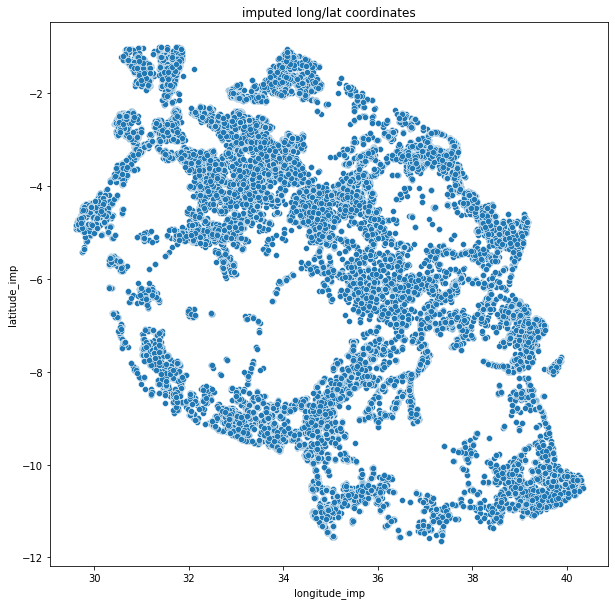

In [189]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=train, x='longitude_imp',y='latitude_imp')
ax.set_title('imputed long/lat coordinates')

In [190]:
# Finally, to reduce extreme cardinality in long/lat values, let's round to 2 decimal places
# That places each water pump within about 1.1 km, which is more than enough for these purposes

In [191]:
train[['longitude_imp','latitude_imp']] = train[['longitude_imp','latitude_imp']].round(2)
X[['longitude_imp','latitude_imp']] = X[['longitude_imp','latitude_imp']].round(2)

### 3.1.7 gps_height / population / construction_year

In [192]:
# I'll take a similar tack for these features.

# for gps_height and population, I'll impute by locality as above.

def locality_impute(df, control, features):
    '''
    Returns list of imputed Series of given features, done by a hierarchy of localities.
    
    In addition, the use of a control dataframe ensures prevention of data leakage.
    
    Arguments:
        df: DataFrame to be imputed
        control: DataFrame to use as a control, to calculate imputed values
        features: list of features (as strings) to impute
    '''
    
    d = df.copy()
    temp = control.copy()
    changes = []
    
    for f in features:
        f=str(f)
        means_sub = temp.groupby(['region', 'lga', 'ward', 'subvillage'])[f].mean().reset_index()
        means_sub = means_sub.rename(columns={f: 'imp_sub'})

        means_ward = temp.groupby(['region', 'lga', 'ward'])[f].mean().reset_index()
        means_ward = means_ward.rename(columns={f: 'imp_ward'})

        means_lga = temp.groupby(['region', 'lga'])[f].mean().reset_index()
        means_lga = means_lga.rename(columns={f: 'imp_lga'})

        means_reg = temp.groupby(['region'])[f].mean().reset_index()
        means_reg = means_reg.rename(columns={f: 'imp_reg'})

        d = d.merge(means_sub, how='left', on=['region','lga','ward','subvillage'])
        d = d.merge(means_ward, how='left', on=['region','lga','ward'])
        d = d.merge(means_lga, how='left', on=['region','lga'])
        d = d.merge(means_reg, how='left', on=['region'])

        new_feat = f"{f}_imp"

        d[new_feat] = np.where(d[f].isna(), d['imp_sub'], d[f])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_ward'], d[new_feat])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_lga'], d[new_feat])
        d[new_feat] = np.where(d[new_feat].isna(), d['imp_reg'], d[new_feat])
        
        if d[new_feat].isna().sum():
            means_basin = temp.groupby(['basin'])[f].mean().reset_index()
            means_basin = means_basin.rename(columns={f: 'imp_basin'})
            
            d = d.merge(means_basin, how='left', on=['basin'])
            
            d[new_feat] = np.where(d[new_feat].isna(), d['imp_basin'], d[new_feat])
            
            d = d.drop(['imp_basin'], axis=1)
            
        d = d.drop(['imp_sub','imp_ward','imp_lga','imp_reg',f], axis=1)
        changes.append(d[new_feat])
    return changes

In [193]:
# First I need to impute NaN into the 0 values of population

train['population'] = np.where(train['population']==0, np.nan, train['population'])
X['population'] = np.where(X['population']==0, np.nan, X['population'])

In [194]:
train_changes = locality_impute(train, train, ['population','gps_height'])
train['population_imp'] = train_changes[0]
train['gps_height'] = train_changes[1]

X_changes = locality_impute(X, train, ['population','gps_height'])
X['population_imp'] = X_changes[0]
X['gps_height'] = X_changes[1]

train = train.drop(['population','gps_height'], axis=1)
X = X.drop(['population','gps_height'], axis=1)

In [195]:
# After playing with various features to use to impute construction_year,
# 'extraction_type' seems to give a varied mean

train.groupby('extraction_type')['construction_year'].mean().reset_index()

extraction_type  construction_year
0                     afridev        2002.316821
1                        cemo        2009.000000
2                      climax        2012.000000
3                     gravity        1995.965949
4               india mark ii        2001.308428
5              india mark iii        2004.126984
6                         ksb        1999.250000
7                        mono        1992.634541
8                 nira/tanira        1999.421166
9                       other        1993.136859
10  other - mkulima/shinyanga        1971.000000
11          other - play pump        2002.620000
12          other - rope pump        2005.810256
13             other - swn 81        2000.346591
14                submersible        1999.321214
15                     swn 80        1996.671370
16                     walimi        2000.000000
17                   windmill        1995.377049

In [196]:
const_mean = train.groupby('extraction_type')['construction_year'].mean().reset_index()
const_mean = const_mean.rename(columns={'construction_year': "const_imp"})

train = train.merge(const_mean, how='left', on='extraction_type')
train['construction_year_imp'] = np.where(train['construction_year'].isna(),
                                          train['const_imp'],
                                          train['construction_year'])
train = train.drop(['const_imp', 'construction_year'], axis=1)

X = X.merge(const_mean, how='left', on='extraction_type')
X['construction_year_imp'] = np.where(X['construction_year'].isna(),
                                      X['const_imp'],
                                      X['construction_year'])
X = X.drop(['const_imp', 'construction_year'], axis=1)

In [197]:
# And finally, population needs to be set to integers (means gave float values, but of course
# people are only measured in integers)

train['population_imp'] = train['population_imp'].astype('int64')
X['population_imp'] = X['population_imp'].astype('int64')

### 3.1.8 amount_tsh_imp

In [198]:
# Since we already imputed NaN values for 0's, I just want to create a feature
# to signify whether amount_tsh is missing or not.

train['amount_tsh_missing'] = np.where(train['amount_tsh_imp'].isna(), 0, 1)
X['amount_tsh_missing'] = np.where(X['amount_tsh_imp'].isna(), 0, 1)

train = train.drop(['amount_tsh_imp'], axis=1)
X = X.drop(['amount_tsh_imp'], axis=1)

## 3.2 Feature Engineering

I'd like to engineer a few features:
* Age of pumps
* Season in which pumps were recorded (because of rainy/dry seasons)
* Region-district
* Extraction - refinement
* Source - refinement

### 3.2.1 age

In [199]:
train['age'] = (train['recorded_year'] - train['construction_year_imp']).astype('int64')
X['age'] = (X['recorded_year'] - X['construction_year_imp']).astype('int64')

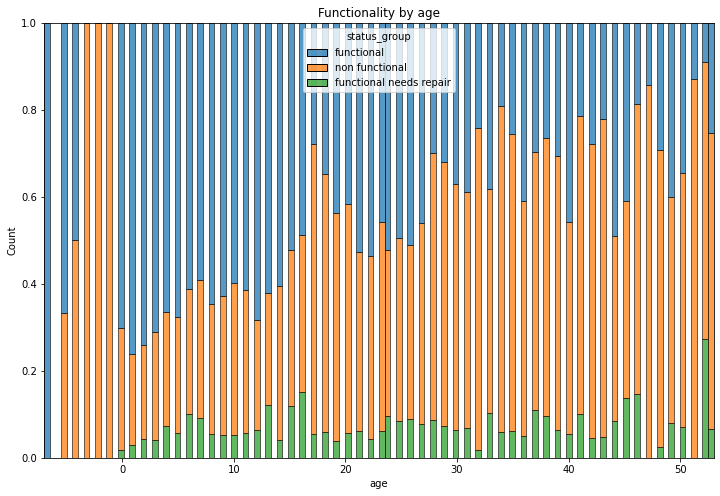

In [200]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train,
            x='age', hue='status_group', multiple='fill')
ax.set_title('Functionality by age');

In [201]:
dist_check(train[train['age']<=0], 'age')

# of pumps  % of all pumps  % functional  % non functional  \
age                                                               
 0          588            94.7          70.2              27.9   
-1           25             4.0           0.0             100.0   
-5            3             0.5          66.7              33.3   
-4            2             0.3          50.0              50.0   
-7            1             0.2         100.0               0.0   
-3            1             0.2           0.0             100.0   
-2            1             0.2           0.0             100.0   

     % functional needs repair  
age                             
 0                         1.9  
-1                         0.0  
-5                         0.0  
-4                         0.0  
-7                         0.0  
-3                         0.0  
-2                         0.0

In [202]:
# Because of imputation of construction_year, there are construction years that are later than
# the recorded date, which is not possible of course. Since there are so few negative values,
# I'll just roll them all into age=0

train['age'] = np.where(train['age']<0, 0, train['age'])
X['age'] = np.where(X['age']<0, 0, X['age'])

### 3.2.2 season

In [203]:
seasons = {1:'s_dry', 2:'s_dry', 3:'l_rain', 4:'l_rain', 5:'l_rain', 
           6:'l_dry', 7:'l_dry', 8:'l_dry',
           9:'l_dry', 10:'l_dry', 11:'s_rain', 12:'s_rain'}

In [204]:
train['month'] = pd.DatetimeIndex(train['date_recorded']).month
X['month'] = pd.DatetimeIndex(X['date_recorded']).month

train['season'] = train['month'].replace(seasons)
X['season'] = X['month'].replace(seasons)

train = train.drop(['month'], axis=1)
X = X.drop(['month'], axis=1)

In [205]:
dist_check(train, 'season')

# of pumps  % of all pumps  % functional  % non functional  \
season                                                               
l_rain       22242            37.4          59.8              34.1   
s_dry        18756            31.6          50.4              40.3   
l_dry        16432            27.7          51.5              41.6   
s_rain        1970             3.3          52.3              43.0   

        % functional needs repair  
season                             
l_rain                        6.1  
s_dry                         9.3  
l_dry                         6.9  
s_rain                        4.6

### 3.2.3 region-district

In [206]:
train['region_district'] = train['region'] + '_' + train['district_code'].astype('str')

In [207]:
X['region_district'] = X['region'] + '_' + X['district_code'].astype('str')

In [208]:
dist_check(train, 'region_district').head(10)

# of pumps  % of all pumps  % functional  % non functional  \
region_district                                                               
Iringa_4               2473             4.2          80.2              16.1   
Shinyanga_3            1404             2.4          55.6              43.5   
Kilimanjaro_4          1225             2.1          58.9              31.2   
Arusha_2               1206             2.0          69.6              26.6   
Shinyanga_1            1196             2.0          49.4              16.1   
Kigoma_2               1159             2.0          57.4              21.7   
Mbeya_4                1106             1.9          61.1              24.3   
Morogoro_1             1094             1.8          53.7              39.7   
Mbeya_6                1034             1.7          43.5              49.7   
Arusha_7               1009             1.7          65.1              31.7   

                 % functional needs repair  
region_district                             
Iringa_4                               3.7  
Shinyanga_3                            0.9  
Kilimanjaro_4                         10.0  
Arusha_2                               3.8  
Shinyanga_1                           34.5  
Kigoma_2                              20.9  
Mbeya_4                               14.6  
Morogoro_1                             6.7  
Mbeya_6                                6.8  
Arusha_7                               3.2

### 3.2.4 extraction

In [209]:
train.groupby(['extraction_type_class','extraction_type_group','extraction_type'])['id'].count().reset_index()

extraction_type_class extraction_type_group            extraction_type  \
0                gravity               gravity                    gravity   
1               handpump               afridev                    afridev   
2               handpump         india mark ii              india mark ii   
3               handpump        india mark iii             india mark iii   
4               handpump           nira/tanira                nira/tanira   
5               handpump        other handpump  other - mkulima/shinyanga   
6               handpump        other handpump          other - play pump   
7               handpump        other handpump             other - swn 81   
8               handpump        other handpump                     walimi   
9               handpump                swn 80                     swn 80   
10             motorpump                  mono                       mono   
11             motorpump       other motorpump                       cemo   
12             motorpump       other motorpump                     climax   
13                 other                 other                      other   
14             rope pump             rope pump          other - rope pump   
15           submersible           submersible                        ksb   
16           submersible           submersible                submersible   
17          wind-powered          wind-powered                   windmill   

       id  
0   26780  
1    1770  
2    2400  
3      98  
4    8154  
5       2  
6      85  
7     229  
8      48  
9    3670  
10   2865  
11     90  
12     32  
13   6430  
14    451  
15   1415  
16   4764  
17    117

In [210]:
# refinement / re-shuffling of swn/cemo-climax/other* extraction types

extracts = {'other - mkulima/shinyanga':'other handpump',
           'other - play pump':'other handpump',
           'walimi':'other handpump',
           'other - swn 81':'swn',
           'swn 80':'swn',
           'cemo':'other motorpump',
           'climax':'other motorpump'}

train['extraction_type'] = train['extraction_type'].replace(extracts)
X['extraction_type'] = X['extraction_type'].replace(extracts)

In [211]:
train.groupby(['extraction_type_class','extraction_type'])['id'].count().reset_index()

extraction_type_class    extraction_type     id
0                gravity            gravity  26780
1               handpump            afridev   1770
2               handpump      india mark ii   2400
3               handpump     india mark iii     98
4               handpump        nira/tanira   8154
5               handpump     other handpump    135
6               handpump                swn   3899
7              motorpump               mono   2865
8              motorpump    other motorpump    122
9                  other              other   6430
10             rope pump  other - rope pump    451
11           submersible                ksb   1415
12           submersible        submersible   4764
13          wind-powered           windmill    117

### 3.2.5 source

In [212]:
train.groupby(['source_class','source_type','source'])['id'].count().reset_index()

source_class           source_type                source     id
0  groundwater              borehole              hand dtw    874
1  groundwater              borehole           machine dbh  11075
2  groundwater          shallow well          shallow well  16824
3  groundwater                spring                spring  17021
4      surface                   dam                   dam    656
5      surface  rainwater harvesting  rainwater harvesting   2295
6      surface            river/lake                  lake    765
7      surface            river/lake                 river   9612
8      unknown                 other                 other    212
9      unknown                 other               unknown     66

In [213]:
# collapse other and unknown into just other
source = {'unknown':'other'}

train['source'] = train['source'].replace(source)
X['source'] = X['source'].replace(source)

## 3.3 Dataframe prep - Dropping and encoding

### 3.3.1 Dropping unnecessary columns

In [214]:
# Up to now I've been dealing with the 'train' and 'X' dataframes,
# in order to prevent data leakage. Now I'll set up final dataframes
# to pass along to modelling.

train_ids = x_train['id']
test_ids = x_test['id']

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 74249
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74250 non-null  object        
 1   amount_tsh             74250 non-null  float64       
 2   date_recorded          74250 non-null  datetime64[ns]
 3   funder                 74250 non-null  object        
 4   installer              74250 non-null  object        
 5   wpt_name               74250 non-null  object        
 6   num_private            74250 non-null  object        
 7   basin                  74250 non-null  object        
 8   subvillage             74250 non-null  object        
 9   region                 74250 non-null  object        
 10  region_code            74250 non-null  object        
 11  district_code          74250 non-null  object        
 12  lga                    74250 non-null  object        
 13  w

In [215]:
to_drop = ['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',
          'region', 'district_code', 'lga', 'ward', 'scheme_management', 'extraction_type_group',
          'extraction_type_class', 'management_group', 'source_type', 'source_class',
          'waterpoint_type_group', 'recorded_year', 'construction_year_imp']

In [216]:
try:
    X = X.drop(to_drop, axis=1)
except:
    pass

In [217]:
X.iloc[:,:10].head()

id   funder     installer                    basin region_code  \
0  69572    Roman         roman               Lake Nyasa          11   
1   8776  Grumeti       grumeti            Lake Victoria          20   
2  34310    other  world vision                  Pangani          21   
3  67743   Unicef        unicef  Ruvuma / Southern Coast          90   
4  19728    other       artisan            Lake Victoria          18   

   public_meeting extraction_type management         payment water_quality  
0               0         gravity        vwc    pay annually          soft  
1               1         gravity        wug       never pay          soft  
2               0         gravity        vwc  pay per bucket          soft  
3               0     submersible        vwc       never pay          soft  
4               0         gravity      other       never pay          soft

In [218]:
X.iloc[:,10:].head()

quantity                source              waterpoint_type  \
0        enough                spring           communal standpipe   
1  insufficient  rainwater harvesting           communal standpipe   
2        enough                   dam  communal standpipe multiple   
3           dry           machine dbh  communal standpipe multiple   
4      seasonal  rainwater harvesting           communal standpipe   

   permit_imp  longitude_imp  latitude_imp  population_imp  \
0           0          34.94         -9.86             109   
1           0          34.70         -2.15             280   
2           0          37.46         -3.82             250   
3           0          38.49        -11.16              58   
4           0          31.13         -1.82             529   

   amount_tsh_missing  age  season region_district  
0                   1   12  l_rain        Iringa_5  
1                   0    3  l_rain          Mara_2  
2                   1    4   s_dry       Manyara_4  
3                   0   27   s_dry       Mtwara_63  
4                   0   15   l_dry        Kagera_1

### 3.3.2 Encoding

In [219]:
train_set = X[X['id'].isin(train_ids)]
test_set = X[X['id'].isin(test_ids)]

y = train['status_group']

In [220]:
cat_cols = [col for col in train_set.drop(['id'],axis=1).columns if train_set[col].dtype=='object']

cat_cols

['funder',
 'installer',
 'basin',
 'region_code',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'season',
 'region_district']

In [221]:
for col in cat_cols:
    LE = LabelEncoder()
    train_set[col] = LE.fit_transform(train_set[col])
    test_set[col] = LE.transform(test_set[col])

In [222]:
train_set.iloc[:,:10].head()

id  funder  installer  basin  region_code  public_meeting  \
0  69572     142        146      1           10               0   
1   8776      60         58      4           19               1   
2  34310     200        198      5           20               0   
3  67743     181        175      7           25               0   
4  19728     200         11      4           17               0   

   extraction_type  management  payment  water_quality  
0                1           7        2              6  
1                1          11        0              6  
2                1           7        4              6  
3               11           7        0              6  
4                1           1        0              6

In [223]:
train_set.iloc[:,10:].head()

quantity  source  waterpoint_type  permit_imp  longitude_imp  latitude_imp  \
0         1       8                1           0          34.94         -9.86   
1         2       5                1           0          34.70         -2.15   
2         1       0                2           0          37.46         -3.82   
3         0       3                2           0          38.49        -11.16   
4         3       5                1           0          31.13         -1.82   

   population_imp  amount_tsh_missing  age  season  region_district  
0             109                   1   12       1               20  
1             280                   0    3       1               55  
2             250                   1    4       2               52  
3              58                   0   27       2               76  
4             529                   0   15       0               22

<a id="model"></a>
# 4. Modelling
[Back to Top](#contents) | [Previous Section](#clean) | [Next Section](#insights)

## 4.1 Data prep and Baseline Models

In [267]:
train_values = train_set.drop(['id'],axis=1)

rand = 42

X_train, X_test, y_train, y_test = train_test_split(train_values, y, test_size=0.2, random_state=rand, stratify=y)

In [228]:
models = [
    LogisticRegression(max_iter=1000000, random_state=rand),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=rand),
    RandomForestClassifier(random_state=rand),
    XGBClassifier(random_state=rand),
    BaggingClassifier(random_state=rand),
    AdaBoostClassifier(random_state=rand),
    GradientBoostingClassifier(random_state=rand)
]

model_names = ['logistic',
              'KNN',
              'decision tree',
              'random forest',
              'XGB',
              'bagging',
              'adaboost',
              'gradient boost']

acc = []
std = []

for model in models:
    print('testing',model,'...')
    cv = KFold(n_splits=10, shuffle=True, random_state=rand)
    n_scores = cross_val_score(model, train_values, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    mean_score = np.mean(n_scores)
    std_score = np.std(n_scores)
    acc.append(mean_score)
    std.append(std_score)
    print(model,mean_score,std_score)
    
model_scores = {'Model':model_names, 'Accuracy':acc, "std":std}
naive_scores = pd.DataFrame(model_scores)
naive_scores

testing LogisticRegression(max_iter=1000000, random_state=42) ...
LogisticRegression(max_iter=1000000, random_state=42) 0.6467676767676768 0.007207982791882881
testing KNeighborsClassifier() ...
KNeighborsClassifier() 0.7131649831649831 0.006133031522926812
testing DecisionTreeClassifier(random_state=42) ...
DecisionTreeClassifier(random_state=42) 0.7608417508417509 0.00528855380699439
testing RandomForestClassifier(random_state=42) ...
RandomForestClassifier(random_state=42) 0.8026767676767678 0.004331836628916591
testing XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=42, r

Model  Accuracy       std
0        logistic  0.646768  0.007208
1             KNN  0.713165  0.006133
2   decision tree  0.760842  0.005289
3   random forest  0.802677  0.004332
4             XGB  0.800842  0.003843
5         bagging  0.790539  0.004245
6        adaboost  0.721902  0.004579
7  gradient boost  0.751296  0.004437

In [229]:
# So the top three models are:
# Random Forest,
# XGBoost,
# Bagging

In [230]:
tuned_scores = {
    "Model":['Random Forest', 'XGBoost', 'Bagging', 'Voting', 'Weighted Voting'],
    "Training accuracy": [np.nan]*5,
    "Testing accuracy": [np.nan]*5,
    "Submission accuracy": [np.nan]*5
}

## 4.2 Individual Models
### 4.2.1 Random Forest

In [231]:
# param_grid = {
#     'n_estimators': [150, 225, 300],
#     'max_features': ['log2'],
#     'max_depth': [20,30],
#     'min_samples_split': [4,7,10]
# }

# rf_clf = RandomForestClassifier(random_state=rand, warm_start=True)

# rf_gscv = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# rf_gscv.fit(X_train, y_train)

# print('Best score', rf_gscv.best_score_)
# print('Parameters', rf_gscv.best_params_)
# print('Best model', rf_gscv.best_estimator_)

In [232]:
best_rf = RandomForestClassifier(max_depth=20, max_features='log2',
                                min_samples_split=4, n_estimators=150, warm_start=True,
                                random_state=42)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

print('Train accuracy:', accuracy_score(y_train, y_pred_train))
print('Test accuracy:', accuracy_score(y_test, y_pred))

Train accuracy: 0.9124579124579124
Test accuracy: 0.806986531986532


In [233]:
tuned_scores['Training accuracy'][0] = (0.9125)
tuned_scores['Testing accuracy'][0] = (0.8070)

In [234]:
sub_rf = RandomForestClassifier(max_depth=20, max_features='log2',
                                min_samples_split=4, n_estimators=150, warm_start=True,
                                random_state=42)

sub_rf.fit(train_values, y)
y_pred = sub_rf.predict(test_set.drop(['id'],axis=1))

rf_sub = pd.DataFrame()
rf_sub['status_group'] = y_pred
rf_sub['id'] = test_ids

rf_sub = rf_sub[['id','status_group']]

In [235]:
#rf_sub.to_csv('submissions/rf_sub.csv', index=False)

In [236]:
tuned_scores['Submission accuracy'][0] = (0.8202)

### 4.2.2 XGBoost

In [237]:
# param_grid = {
#     'n_estimators': [100,200],
#     'colsample_bytree' :[0.3,0.5],
#     'eta': [0.2,0.5],
#     'max_depth': [8,12]
# }

# xgb_clf = XGBClassifier(random_state=rand, eval_metric='mlogloss')

# xgb_gscv = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy')

# xgb_gscv.fit(X_train, y_train)

# print('Best score', xgb_gscv.best_score_)
# print('Parameters', xgb_gscv.best_params_)
# print('Best model', xgb_gscv.best_estimator_)

In [238]:
best_xgb = XGBClassifier(colsample_bytree=0.3, eta=0.2, max_depth=12,
                        n_estimators=100, random_state=rand, eval_metric='mlogloss')

best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
y_pred_train = best_xgb.predict(X_train)

print('Train accuracy:', accuracy_score(y_train, y_pred_train))
print('Test accuracy:', accuracy_score(y_test, y_pred))

Train accuracy: 0.9194234006734007
Test accuracy: 0.813047138047138


In [239]:
tuned_scores['Training accuracy'][1] = (0.9194)
tuned_scores['Testing accuracy'][1] = (0.8130)

In [240]:
sub_xgb = XGBClassifier(colsample_bytree=0.3, eta=0.2, max_depth=12,
                        n_estimators=100, random_state=rand, eval_metric='mlogloss')

sub_xgb.fit(train_values, y)
y_pred = sub_xgb.predict(test_set.drop(['id'],axis=1))

xgb_sub = pd.DataFrame()
xgb_sub['status_group'] = y_pred
xgb_sub['id'] = test_ids

xgb_sub = xgb_sub[['id','status_group']]

In [241]:
#xgb_sub.to_csv('submissions/xgb_sub.csv', index=False)

In [242]:
tuned_scores['Submission accuracy'][1] = (0.8184)

### 4.2.3 Bagging

In [243]:
# Create training and test sets: test size 0.2
# param_grid = { 'n_estimators': [100, 600, 1200],
#               'max_features': [0.2, 0.4, 0.6]}

    

#Create a based model
# bag = BaggingClassifier(random_state=rand)

# bag_gscv = GridSearchCV(estimator=bag, param_grid=param_grid, cv=5,
#                         verbose=True, scoring='accuracy')

#fitmodel
#bag_gscv.fit(X_train, y_train )

#print best parameters 
# print('Best Score:', bag_gscv.best_score_)
# print('Parameters:', bag_gscv.best_params_)
# print('Best Model:',bag_gscv .best_estimator_)

# Because of long calculation times, google colab was used to find optimal values

In [244]:
best_bag = BaggingClassifier(random_state=rand, n_estimators=1200,
                            max_features=0.6)

best_bag.fit(X_train, y_train)
y_pred = best_bag.predict(X_test)
y_pred_train = best_bag.predict(X_train)

print('Train accuracy:', accuracy_score(y_train, y_pred_train))
print('Test accuracy:', accuracy_score(y_test, y_pred))

Train accuracy: 0.9706649831649832
Test accuracy: 0.8073232323232323


In [245]:
tuned_scores['Training accuracy'][2] = (0.9707)
tuned_scores['Testing accuracy'][2] = (0.8073)

In [246]:
sub_bag = BaggingClassifier(random_state=rand, n_estimators=1200,
                            max_features=0.6)
sub_bag.fit(train_values, y)
y_pred = sub_bag.predict(test_set.drop(['id'],axis=1))

bag_sub = pd.DataFrame()
bag_sub['status_group'] = y_pred
bag_sub['id'] = test_ids

bag_sub = bag_sub[['id','status_group']]

In [247]:
#bag_sub.to_csv('submissions/bag_sub.csv', index=False)

In [248]:
tuned_scores['Submission accuracy'][2] = (0.8166)

### 4.2.4 Voting Classifier

In [249]:
rf = RandomForestClassifier(max_depth=20, max_features='log2',
                                min_samples_split=4, n_estimators=150, warm_start=True,
                                random_state=42)
xgb = XGBClassifier(colsample_bytree=0.3, eta=0.2, max_depth=12,
                        n_estimators=100, random_state=rand, eval_metric='mlogloss')
bag = BaggingClassifier(random_state=rand, n_estimators=1200,
                            max_features=0.6)

In [250]:
vc = VotingClassifier([('rf', rf), ('xgb', xgb), ('bag', bag)], voting = 'soft')
                       

#fit and predict
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_train = vc.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score train: 0.9399200336700336
Accuracy score test: 0.8146464646464646


In [251]:
tuned_scores['Training accuracy'][3] = (0.9399)
tuned_scores['Testing accuracy'][3] = (0.8146)

In [252]:
sub_vc = VotingClassifier([('rf', rf), ('xgb', xgb), ('bag', bag)], voting = 'soft')

sub_vc.fit(train_values, y)
y_pred = sub_vc.predict(test_set.drop(['id'],axis=1))

bag_vc = pd.DataFrame()
bag_vc['status_group'] = y_pred
bag_vc['id'] = test_ids

bag_vc = bag_vc[['id','status_group']]

In [253]:
#bag_vc.to_csv('submissions/bag_vc.csv', index=False)

In [254]:
tuned_scores['Submission accuracy'][3] = (0.8218)

### 4.2.5 Weighted Voting Classifier

In [256]:
rf = RandomForestClassifier(max_depth=20, max_features='log2',
                                min_samples_split=4, n_estimators=150, warm_start=True,
                                random_state=42)
xgb = XGBClassifier(colsample_bytree=0.3, eta=0.2, max_depth=12,
                        n_estimators=100, random_state=rand, eval_metric='mlogloss')
bag = BaggingClassifier(random_state=rand, n_estimators=1200,
                            max_features=0.6)

In [257]:
wvc = VotingClassifier([('rf', rf), ('xgb', xgb), ('bag', bag)], voting = 'soft', weights=[1,0.9,0.8])
                       

#fit and predict
wvc.fit(X_train, y_train)
y_pred = wvc.predict(X_test)
y_pred_train = wvc.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))

Accuracy score train: 0.9379840067340067
Accuracy score test: 0.8144781144781145


In [258]:
tuned_scores['Training accuracy'][4] = (0.9380)
tuned_scores['Testing accuracy'][4] = (0.8145)

In [259]:
sub_wvc = VotingClassifier([('rf', rf), ('xgb', xgb), ('bag', bag)], voting = 'soft')

sub_wvc.fit(train_values, y)
y_pred = sub_wvc.predict(test_set.drop(['id'],axis=1))

bag_wvc = pd.DataFrame()
bag_wvc['status_group'] = y_pred
bag_wvc['id'] = test_ids

bag_wvc = bag_wvc[['id','status_group']]

In [260]:
#bag_wvc.to_csv('submissions/bag_wvc.csv', index=False)

In [261]:
tuned_scores['Submission accuracy'][4] = (0.8218)

## 4.3 Results

In [262]:
pd.DataFrame(tuned_scores)

Model  Training accuracy  Testing accuracy  Submission accuracy
0    Random Forest             0.9125            0.8070               0.8202
1          XGBoost             0.9194            0.8130               0.8184
2          Bagging             0.9707            0.8073               0.8166
3           Voting             0.9399            0.8146               0.8218
4  Weighted Voting             0.9380            0.8145               0.8218

![best_submission](images/best_submission.png)

<a id="insights"></a>
# 5. Data Insights
[Back to Top](#contents) | [Previous Section](#model) | [Next Section](#conclusion)
## Overview

Business goal:
As a data scientist working for the government of Tanzania, my goal is to create a model to predict which water pumps need to be inspected, repaired, and which do not. Due to the vast number of water pumps across the country, being able to prioritize which pumps and areas to send inspectors and repair/maintenance workers is very important.

In addition, I also am tasked with identifying limitations in the data. Some of these may be overcome through good data preparation practices, but suggestions for future refinement and better data collection will also be determined and provided.

1. Model - features, accuracy, issues

2. Data limitations
* amount_tsh - missing data, derived feature
* Funder / installer - standardization
* Construction year gaps - visualized regionally




## 5.1 Model

Based on the scores displayed above, the highest-performing models are the voting classifiers. Since the weighted version has virtually identical performance, I'll stick with the 'vanilla' version.

Let's see the accuracy plotted geographically:

In [268]:
y_pred_test = vc.predict(X_test)

In [269]:
Xy_test_results = X_test
Xy_test_results['status_group'] = y_test
Xy_test_results['status_pred'] = y_pred_test
Xy_test_results['correct'] = Xy_test_results['status_group']==Xy_test_results['status_pred']

In [270]:
Xy_test_results['correct'].value_counts(normalize=True)

True     0.814646
False    0.185354
Name: correct, dtype: float64

Text(0.5, 1.0, 'Correctly Predicted status_group')

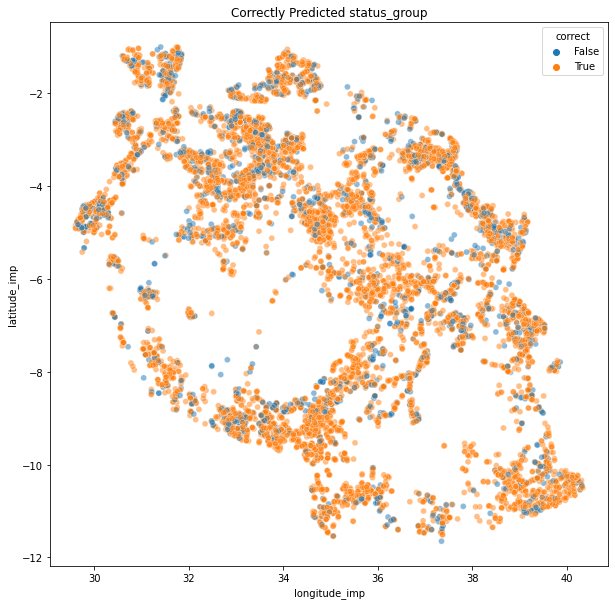

In [271]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=Xy_test_results, x='longitude_imp',y='latitude_imp', hue='correct', alpha=.5)
ax.set_title('Correctly Predicted status_group')

We can see that the misses are pretty evenly distributed geographically.

How about divided up among the three status_group categories?

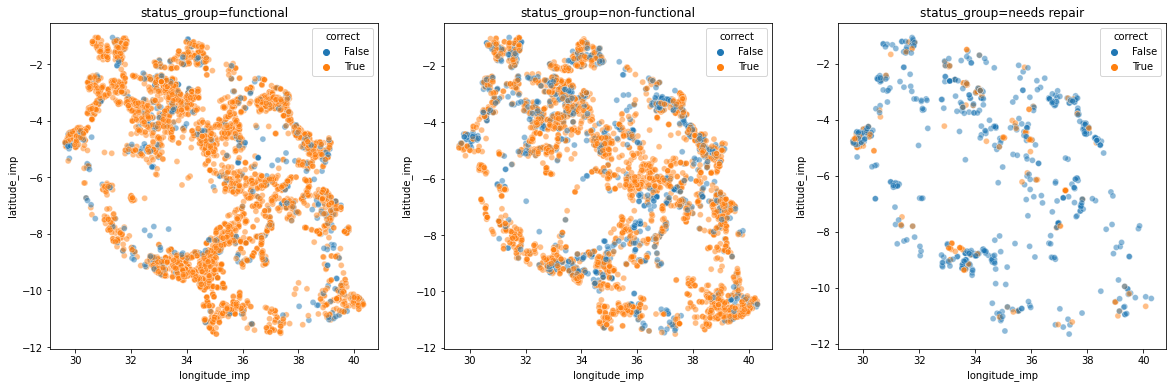

In [272]:
func_results = Xy_test_results[Xy_test_results['status_group']=='functional']
non_results = Xy_test_results[Xy_test_results['status_group']=='non functional']
rep_results = Xy_test_results[Xy_test_results['status_group']=='functional needs repair']

status_results = [func_results, non_results, rep_results]
statii = ['functional','non-functional','needs repair']

f = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
for df in status_results:
    ax = axes[f]
    sns.scatterplot(data=df, x='longitude_imp',y='latitude_imp', hue='correct', alpha=.5, ax=ax)
    ax.set_title(f"status_group={statii[f]}")
    f+=1

As we can see, a major limitation is that the relatively rare status of 'functional needs repair' is very hard to predict for. 'non functional' doesn't look great either, but at least the largest group 'functional' is very well predicted.

It might be easier for a future project to reclassify all pumps as either functional or not, either rolling the 'needs repair' status into one of the others, or finding some other way to split it up based on some metric.

To speculate, if a pump needs repair, it will need work done just as a non-functional pump would, so perhaps they should be classified as the same; conditions leading to a pump needing repair are likely the same that would lead it to be non-functional, and further, 'needs repair' pumps are likely just going to be non-functional soon anyway.

## 5.2 Data limitations

### 5.2.1 amount_tsh

This feature is described as:

amount_tsh - Total static head (amount water available to waterpoint)

I'm not sure what this  denotes exactly, and the dataset seems unusual. Over 70% of pumps have an amount_tsh value of 0, which likely means that there is simply no data for that pump's amount_tsh. It would be hard to believe that 70% of the pumps in the dataset have no water available!

In investigating this, since there are so few pumps with a value at all, and since most of those have rounded values anyway (1000, 500, etc) there isn't likely much information to be gained from trying to impute this.

However, the mere fact of having the missing/0 value seems to have a large effect on average functionality - as shown below.

In [313]:
x_tr_ex = pd.read_csv('x_train.csv')
x_tr_ex['status_group'] = train['status_group']

In [314]:
tsh_df = dist_check(x_tr_ex, 'amount_tsh').reset_index()
tsh_df.head(10)

amount_tsh  # of pumps  % of all pumps  % functional  % non functional  \
0         0.0       41639            70.1          47.3              45.4   
1       500.0        3102             5.2          71.8              19.4   
2        50.0        2472             4.2          66.1              29.6   
3      1000.0        1488             2.5          75.3              18.9   
4        20.0        1463             2.5          66.3              28.5   
5       200.0        1220             2.1          64.7              25.5   
6       100.0         816             1.4          68.3              24.4   
7        10.0         806             1.4          77.3              20.7   
8        30.0         743             1.3          71.1              24.2   
9      2000.0         704             1.2          74.1              21.4   

   % functional needs repair  
0                        7.3  
1                        8.8  
2                        4.3  
3                        5.8  
4                        5.2  
5                        9.8  
6                        7.4  
7                        2.0  
8                        4.7  
9                        4.4

In [315]:
def tsh_bins(x):
    b = '0'
    if x == 0:
        return b
    if x > 0:
        b = '0-50'
    if x > 50:
        b = '50-500'
    if x > 500:
        b = '500-5000'
    if x > 5000:
        b = '5000-max'
    return b

In [316]:
x_tr_ex['tsh_bin'] = x_tr_ex['amount_tsh'].apply(tsh_bins)

In [317]:
tsh_df = dist_check(x_tr_ex, 'tsh_bin').reset_index()
tsh_df.head(10)

tsh_bin  # of pumps  % of all pumps  % functional  % non functional  \
0         0       41639            70.1          47.3              45.4   
1      0-50        6600            11.1          71.2              25.0   
2    50-500        6414            10.8          67.5              22.0   
3  500-5000        4277             7.2          73.3              19.1   
4  5000-max         470             0.8          83.2              13.0   

   % functional needs repair  
0                        7.3  
1                        3.9  
2                       10.4  
3                        7.6  
4                        3.8

Text(0.5, 1.0, 'Geographic plot of amount_tsh bins')

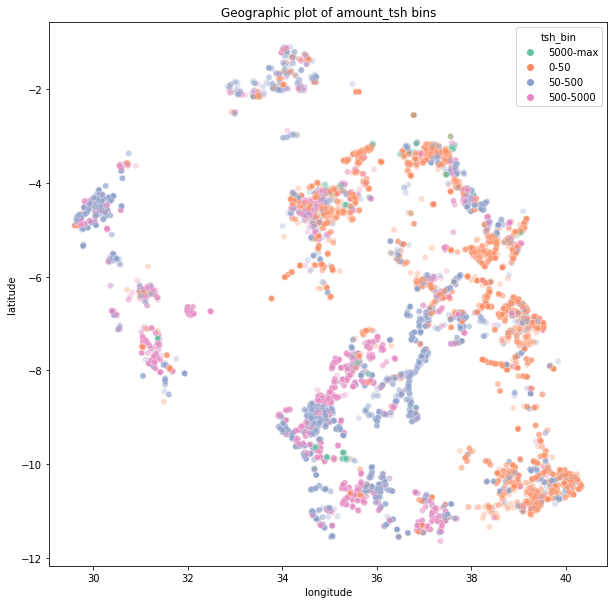

In [318]:
non_zero = x_tr_ex[(x_tr_ex['longitude']>0) & (x_tr_ex['tsh_bin']!='0')]

plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=non_zero, x='longitude',y='latitude', hue='tsh_bin', alpha=.3, palette='Set2')
ax.set_title('Geographic plot of amount_tsh bins')

In addition, this display of amount_tsh bins shows that of these approximately 30% of pumps are clustered strongly by these bins - it's not likely that this data will add much more than is already added by location data, region/district data, and other info. As well, the average functionality across these pumps is largely consistent in any case.

### 5.2.2 installer / funder

These features present a major problem in their disparate spelling, capitalization, and punctuation/spacing. This results in extreme cardinality. My two solutions to this problem were:

* Finding the most similar names (strings) among the top 300 unique values and correcting them
* Grouping all the unique values under a certain threshold into 'other'

However, this had to be done manually, and since I am not familiar with many of the names, very slight differences in spelling of words (especially in the native languages) were not always obvious as to whether they were in fact the same funder/installer, or if they were distinct. I tended to be conservative, and only consolidated the most obvious ones - e.g., "Unice" was likely a misspelling of "Unicef".

Below we can see the top 10 installers, before and after data cleaning:

In [319]:
dist_check(x_tr_ex, 'installer').head(10).reset_index().iloc[:,:2]

installer  # of pumps
0                 DWE       17402
1          Government        1825
2                 RWE        1206
3               Commu        1060
4              DANIDA        1050
5                KKKT         898
6              Hesawa         840
7                   0         777
8                TCRS         707
9  Central government         622

In [320]:
dist_check(train, 'installer').head(10).reset_index().iloc[:,:2]

installer  # of pumps
0               dwe       17405
1             other        9342
2        government        1891
3            danida        1674
4         community        1674
5            hesawa        1395
6               rwe        1206
7  district council         974
8              kkkt         910
9                 0         777

### 5.2.3 construction_year - missingness

In [321]:
for col in ['amount_tsh', 'longitude', 'latitude', 'gps_height', 'construction_year', 'population']:
    x_tr_ex[col] = np.where(x_tr_ex[col].round(2)==0, np.nan, x_tr_ex[col])

<AxesSubplot:>

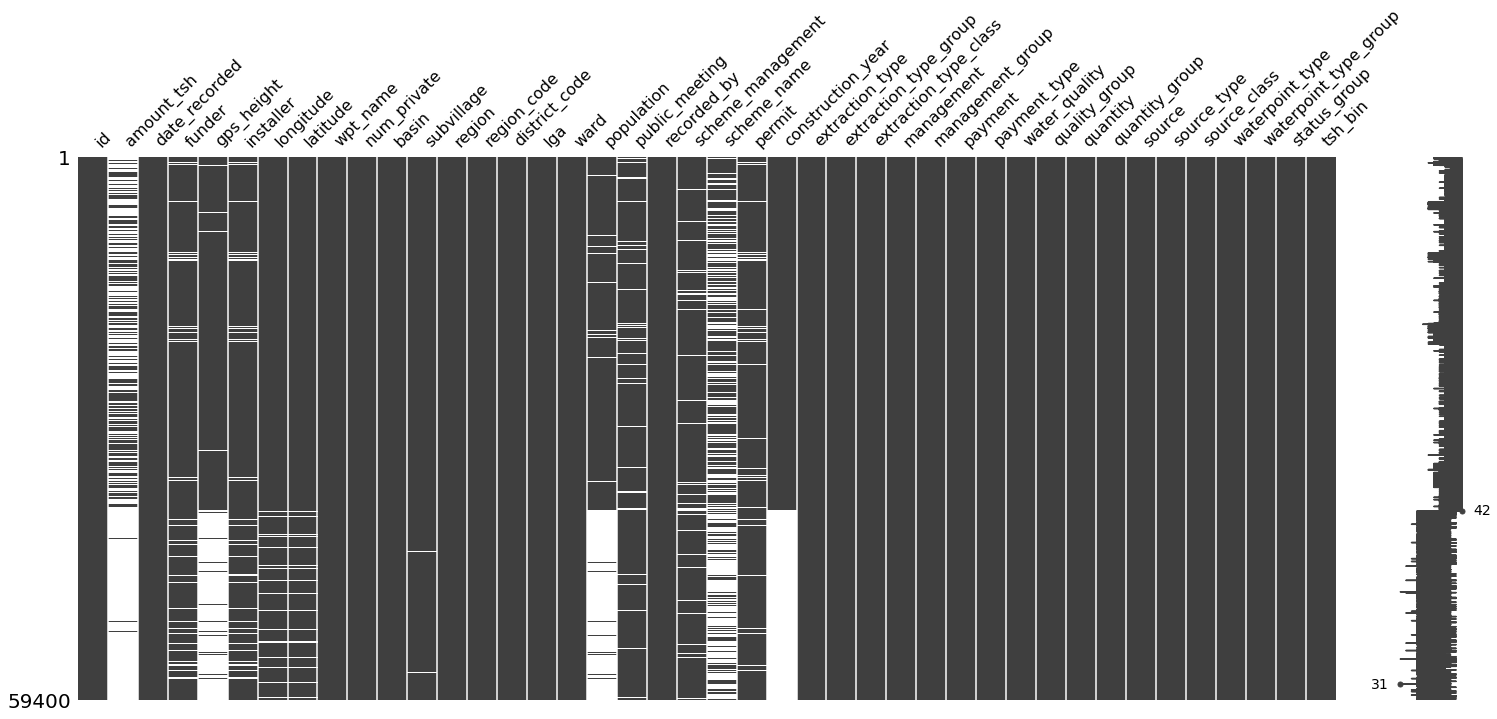

In [322]:
msno.matrix(x_tr_ex.sort_values('construction_year'))

We can see that by sorting by construction_year, there is a clear correlation among the features' missingness.

amount_tsh, funder, installer, gps_height, longitude, latitude, population, and possibly even scheme_name are all 'more missing' in those pumps with missing construction_year data.

Because of this, my strategy of imputing had to be a little more nuanced. 

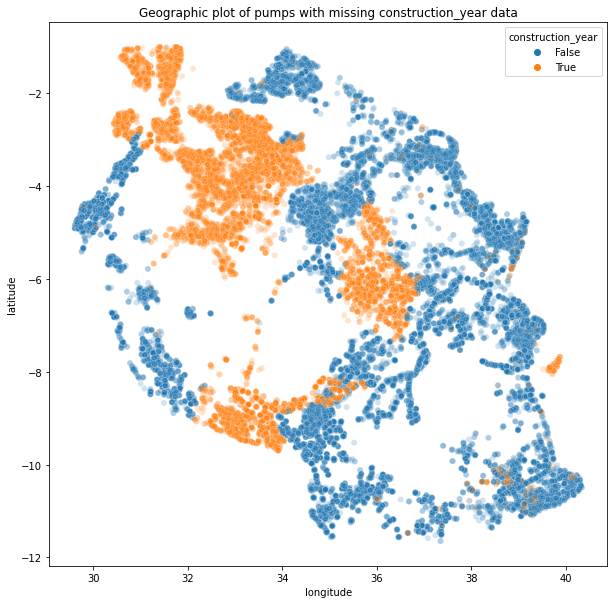

In [323]:
non_zero = x_tr_ex[(x_tr_ex['longitude']>0)]

plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=non_zero, x='longitude',y='latitude',
                     hue=x_tr_ex['construction_year'].isna(), alpha=.2)
ax.set_title('Geographic plot of pumps with missing construction_year data');

The heavy geographic clustering of this data means that all of the aforementioned correllated features are also more missing in these areas. Thus when imputing missing values, I often had to find ways of imputation that would not be based on geographic or regional criteria. For construction_year itself, I needed to use 'extraction_type' to help fill the gaps.

This is not a perfect strategy, and is a compromise between losing these important features and introducing 'bad' data through imputation.

I prioritized including construction_year especially since there is such a strong correlation with the target variable:

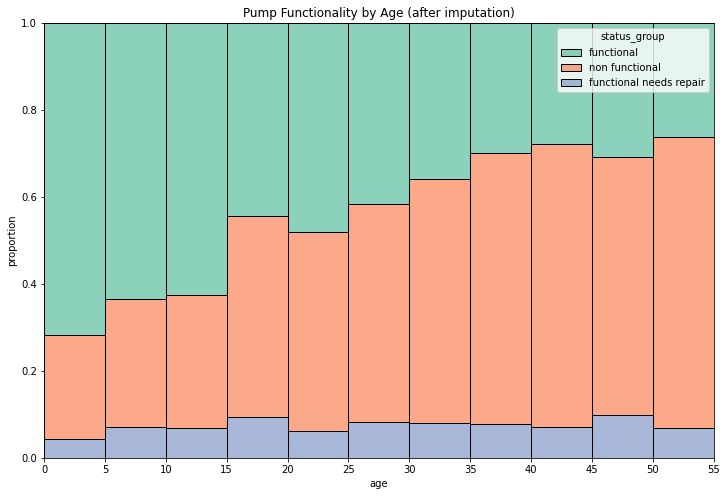

In [324]:
plt.figure(figsize=(12,8))
ax = sns.histplot(data=train, x='age', hue='status_group', multiple='fill', binwidth=5, palette='Set2')
ax.set_title('Pump Functionality by Age (after imputation)')
ax.set_ylabel('proportion')
ax.set_xticks(list(range(0,60,5)));

## 5.3 Recommendations

Based on the insights above, I would make three recommendations:

### 5.3.1 Efficient targeting of areas
* Efforts to dispatch inspectors and maintenance personnel should focus on geographic and region-districts that have the highest incidence of non-functionality. These can be shown below:
* The first figure shows that the far south-east area is highly non-functional (orange)
* The second figure is a table showing the region-districts with highest non-functionality
* Finally, regional prediction could be used as well

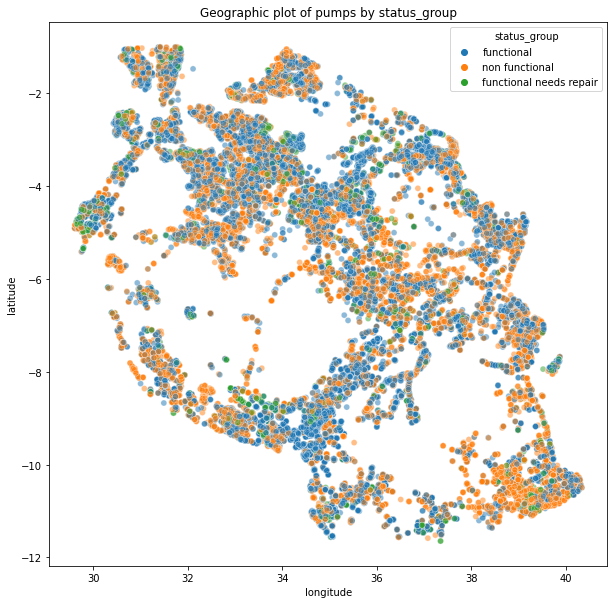

In [325]:
non_zero = x_tr_ex[(x_tr_ex['longitude']>0)]

plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=non_zero, x='longitude',y='latitude',
                     hue=non_zero['status_group'], alpha=.5)
ax.set_title('Geographic plot of pumps by status_group');

In [326]:
dist_check(train, 'region_district').sort_values('% non functional', ascending=False).head(10)

# of pumps  % of all pumps  % functional  % non functional  \
region_district                                                               
Lindi_1                   1             0.0           0.0             100.0   
Lindi_3                 300             0.5           8.7              86.3   
Kigoma_4                 56             0.1          23.2              76.8   
Tanga_5                 293             0.5          22.2              76.8   
Lindi_53                291             0.5          17.9              75.3   
Dodoma_0                 23             0.0          17.4              73.9   
Mara_6                  248             0.4          26.2              73.4   
Mtwara_63               158             0.3          26.6              73.4   
Lindi_43                154             0.3          25.3              72.7   
Lindi_2                   7             0.0          28.6              71.4   

                 % functional needs repair  
region_district                             
Lindi_1                                0.0  
Lindi_3                                5.0  
Kigoma_4                               0.0  
Tanga_5                                1.0  
Lindi_53                               6.9  
Dodoma_0                               8.7  
Mara_6                                 0.4  
Mtwara_63                              0.0  
Lindi_43                               1.9  
Lindi_2                                0.0

#### Regional prediction

Along those lines, I'd like to show a possible implementation of regional prediction, since inspectors/pump workers - whether sent out to remote areas, or hired to work permanently in certain areas/districts - would likely need to work on all the pumps in an area, rather than going out to one single pump at a time.

Let's see how the predicted functionality rate within each region-district compares to the actual:

In [304]:
Xy_test_results['func'] = Xy_test_results['status_group']=='functional'
Xy_test_results['non_func'] = Xy_test_results['status_group']!='functional'
Xy_test_results['func_pred'] = Xy_test_results['status_pred']=='functional'
Xy_test_results['non_func_pred'] = Xy_test_results['status_pred']!='functional'

rd_df = Xy_test_results.groupby('region_district')[['func', 'non_func', 'func_pred', 'non_func_pred']].sum().reset_index()

rd_df['func_rate'] = rd_df['func'] / (rd_df['func'] + rd_df['non_func'])
rd_df['func_rate_pred'] = rd_df['func_pred'] / (rd_df['func_pred'] + rd_df['non_func_pred'])

rd_df['pumps'] = rd_df['func'] + rd_df['non_func']
rd_df['delta'] = rd_df['func_rate_pred'] - rd_df['func_rate']

rd_df[['pumps','func_rate','func_rate_pred', 'delta']]

pumps  func_rate  func_rate_pred     delta
0       34   0.617647        0.529412 -0.088235
1      240   0.725000        0.841667  0.116667
2       24   0.750000        0.791667  0.041667
3       64   0.953125        1.000000  0.046875
4       42   0.547619        0.738095  0.190476
..     ...        ...             ...       ...
126     16   0.562500        0.250000 -0.312500
127     53   0.169811        0.132075 -0.037736
128     55   0.509091        0.654545  0.145455
129     22   0.318182        0.272727 -0.045455
130     53   0.754717        0.773585  0.018868

[131 rows x 4 columns]

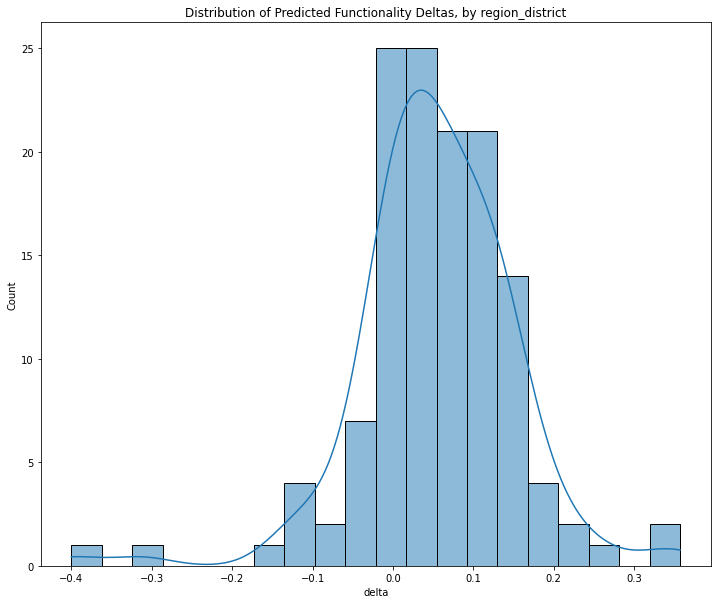

In [312]:
rd_df = rd_df.sort_values(by='pumps',ascending=False)

fig, ax = plt.subplots(figsize=(12,10))

sns.histplot(data=rd_df, x='delta', bins=20, kde=True)
ax.set_title('Distribution of Predicted Functionality Deltas, by region_district');

By using region_district, we are looking at 131 different areas in Tanzania, and after predicting the functionality rate of each, the vast majority are within .1 (10%) of the actual rate, with a bias towards over-estimating.

This could be used to determine those areas with lowest functionality, so resources can be targeted there.

### 5.3.2 Collecting Missing Data

* Efforts to fill in the missing data for these pumps should focus on the regions highlighted in the chart above, with missing construction_year data. This would allow for many of the features to be filled and for the dataset to be much closer to being complete, without doing an exhaustive nationwide re-collection of data.

### 5.3.3 Correcting / Standardizing Data

* There should be a comprehensive audit of the funder/installer features, to determine exactly which of the many many unique values should be consolidated, and which are unique. There would still likely be high cardinality in these features, but it would be great to have the data at least be consistent and correct as much as possible.

<a id="conclusion"></a>
# 6. Conclusion
[Back to Top](#contents) | [Previous Section](#insights)

## 6.1 Final Thoughts

After extensive data cleaning, I'm pleased with the results of the model, and the insights about the dataset as a whole. With more time (or in the hypothetical scenario, more funding from the government of Tanzania) I could likely prototype and experiment more thoroughly and push the accuracy up a bit, but since the highest score on DrivenData is 0.8294, I feel confident that there isn't much more room for improvement except on the margins.

Along those lines, I wasn't very concerned with the aspects of recall/precision/accuracy and the intricacies of the confusion matrix, and with trying to fine-tune false positives vs false negatives (or false-functional, false... etc). The reason for this is that in this scenario, getting overall accuracy is really the goal here, since most of the water pumps are clustered in villages, wards, lga's, etc, and when you're sending people out across the country to do inspections and maintenance, you would likely want to hit lots of pumps at once on the same trip, rather than pinpointing individual pumps. Thus, merely having a good overall accuracy about most pumps in an area will yield good results and help increase efficiency.

## 6.2 Future Work

The two biggest areas for improvement of this work would be:
* Improving my own knowledge of Tanzania and its regions, language, etc, to better clean, organize, and then model the water pump data. I feel I did pretty well on this project, but having access to experts in the country, and being able to ask questions about the areas, would allow me to have a more nuanced approach to the data as a whole.
* Having more time/computation power, to run more exhaustive model/parameter tests, to squeeze out a few more 0.1/0.01% of accuracy.